# TODO

Die Folder mit den Datensaetzen brauchen noch einheitliche Namen.


# Dissimilarity measures and their ability to separate biological groups in microbial abundance data sets

Microbial taxa count tables are multivariate in that each bacterial abundance is a variable that differs between samples.
During the last century, ecologists have developed a rich toolbox of statistical methods to analyze multivariate ecological abundance data.
Many of these methods originally developed for plant or animal related ecology were readily incorporated into microbiome research.
Among these methods, dissimilarity functions are very popular. They allow the calculation of pairwise dissimilarities between communities based on the differences between
abundances in observed species counts. In traditional ecology, these could be the numbers of different trees found within a given area, whereas
in microbial ecology, these are the abundances of bacterial taxa found in communities.

Usually, microbiome researchers visualize pairwise dissimilarities between microbial communities using ordination methods. Based on pairwise dissimilarity matrices, ordination methods project samples into lower dimensions (usually two or three dimensions for visualization purposes) so that the pairwise dissimilarities are preserved well. This allows visual analysis of the global structure of the dataset especially to similarity of samples within and between biological groups.

Let's start off by computing pairwise dissimilarities between microbial communities of different ocean depths and visualizing the data using PCoA (principle coordination analysis) to see if there are differences in microbial community composition between communities living in different depths.

In [161]:
# Load libraries
library(dplyr)
library(vegan)
## Functions for visualization
library(reshape)
library(ggplot2)
library(RColorBrewer)


In [162]:
# Load dataset, label (and tree if available)
curr_workdir <- getwd()
TARA_OceanLayers <- read.table(file=paste(curr_workdir, "/Datasets/Sunagawa_OceanLayers/Sunagawa_OceanLayers", sep = ""), sep='\t', header=TRUE, row.names=1, check.names=FALSE, quote='', comment.char='#')
TARA_OceanLayers.label <- read.table(file=paste(curr_workdir, "/Datasets/Sunagawa_OceanLayers/Sunagawa_OceanLayers.label", sep = ""), sep='\t', header = FALSE, stringsAsFactors=TRUE, row.names=1, check.names=FALSE, quote='', comment.char='#')

In [163]:
# Let's get an idea what we are looking at
print("Dimensions of the dataset")
print(dim(TARA_OceanLayers))
print("Which ocean layers are we trying to distinguish and how many are there?")
print(table(TARA_OceanLayers.label[,1]))

[1] "Dimensions of the dataset"
[1] 765 150
[1] "Which ocean layers are we trying to distinguish and how many are there?"

MES SUR 
 37 113 


We are looking at 150 samples (37 of which come from the mesopelagic zone and 113 come from the surface).
In total, 765 distinct taxonomic units were found over all 150 samples.

Lets calculate pairwise dissimilarities between these samples and visualize them using PCoA.

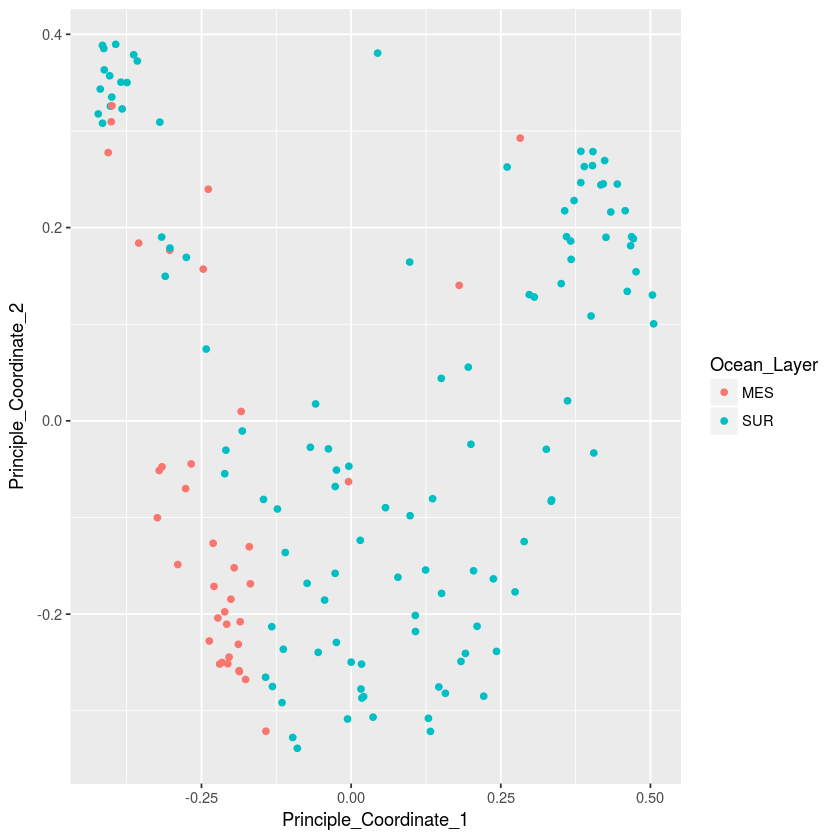

In [164]:
# Normalize for differences in library size by transforming absolute counts into relative abundances
TARA_OceanLayers <- apply(TARA_OceanLayers, 2, function(x) x / sum(x))
    
# Remove the unmapped fraction (Representing the reads that could not be mapped to anything.)    
TARA_OceanLayers <- TARA_OceanLayers[-1, ]

# Calculate Bray-Curtis dissimilarity between samples. We are using the vegdist function from the vegan package.
# Remove empty taxa if there are any.
rowsums <- rowSums(TARA_OceanLayers)
if (any(rowsums == 0)){
    remove_idx <- which(rowsums == 0)
    TARA_OceanLayers <- TARA_OceanLayers[-remove_idx, ]
}

# Calculate pairwise dissimilarities using the Bray-Curtis dissimilarity.
# We have to transpose the abundance table.
pairw_diss_bray <- vegdist(t(TARA_OceanLayers), method = "bray")

# Compute PCoA and visualize.
pcoa_ob <- cmdscale(pairw_diss_bray, k = 2)
pcoa_ob <- as.data.frame(pcoa_ob)
pcoa_ob$Ocean_Layer <- TARA_OceanLayers.label[,1]

# Visualize
colnames(pcoa_ob) <- c("Principle_Coordinate_1", "Principle_Coordinate_2", "Ocean_Layer")

ggplot(pcoa_ob, aes(Principle_Coordinate_1, Principle_Coordinate_2, color = Ocean_Layer)) + geom_point()


The projections of pairwise Bray-Curtis dissimilarities show that most samples coming from the mesopelagic zone are more similar to each other than to samples coming from the ocean surface. Let's do the same using the euclidean dissimilarity.

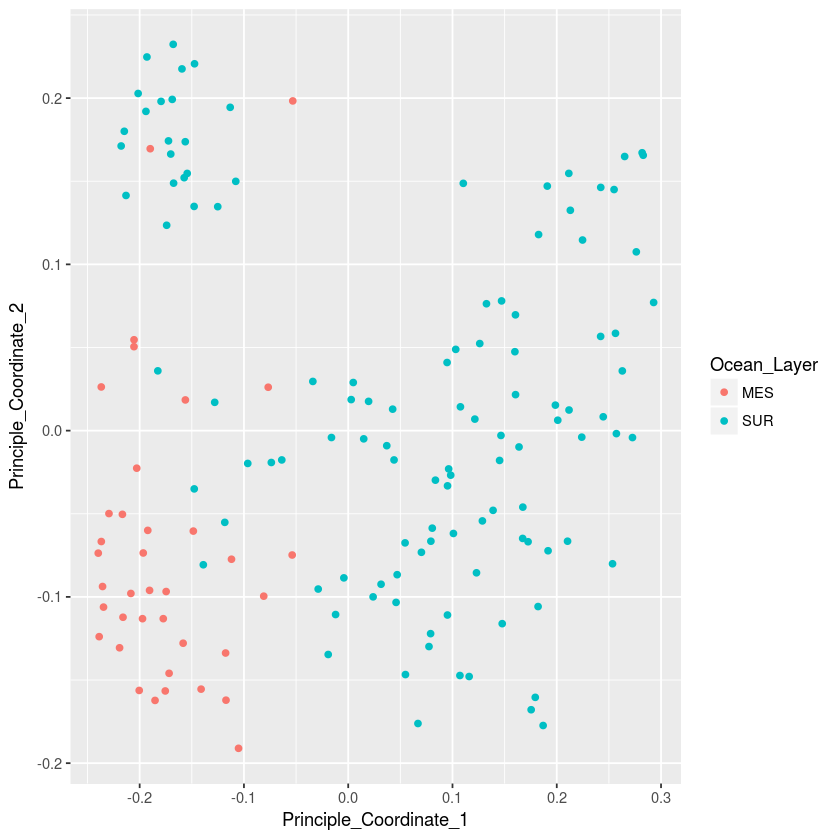

In [165]:
# Normalize for differences in library size by transforming absolute counts into relative abundances
TARA_OceanLayers <- apply(TARA_OceanLayers, 2, function(x) x / sum(x))
    
# Remove the unmapped fraction (Representing the reads that could not be mapped to anything.)
TARA_OceanLayers <- TARA_OceanLayers[-1, ]

# Calculate Canberra dissimilarities between samples. We are using the vegdist function from the vegan package.
# Remove empty taxa if there are any.
rowsums <- rowSums(TARA_OceanLayers)
if (any(rowsums == 0)){
    remove_idx <- which(rowsums == 0)
    TARA_OceanLayers <- TARA_OceanLayers[-remove_idx, ]
}

# Calculate pairwise dissimilarities using the Canberra dissimilarity.
# We have to transpose the abundance table.
pairw_diss_canberra <- vegdist(t(TARA_OceanLayers), method = "canberra")

# Compute PCoA and visualize.
pcoa_ob <- cmdscale(pairw_diss_euclidean, k = 2)
pcoa_ob <- as.data.frame(pcoa_ob)
pcoa_ob$Ocean_Layer <- TARA_OceanLayers.label[,1]

# Visualize
colnames(pcoa_ob) <- c("Principle_Coordinate_1", "Principle_Coordinate_2", "Ocean_Layer")

ggplot(pcoa_ob, aes(Principle_Coordinate_1, Principle_Coordinate_2, color = Ocean_Layer)) + geom_point()

The Canberra dissimilarity appears to provide better group separation compared to the Bray-Curtis dissimilarity. TO Georg: Der Unterschied ist visuell nicht sehr auffallend. Anderer Datensatz / Distanz?

Generally, there is a very large number of distinct dissimilarity measures that could be used to quantify differences between microbial communities. To illustrate, the popular analysis package Phyloseq offers 46 different dissimilarity measures. How can we find out how well they are suited for group separation in microbial abundance analysis? 

Further remember that right now, we are observing the projections of pairwise dissimilaritie of samples provided by PCoA. It is not clear how strongly these projections distort the true underlying clustering in the pairwise dissimilarity matrix. How can we quantify how strongly group separation suffers from separation into lower dimensional space?

A sensible way of evaluating the separability of biological groups in pairwise dissimilarity space (be it the original the pairwise dissimilarities provided by different dissimilarity measures or the Euclidean dissimilarities of points in two dimensional projections) is to consider the neighborhood of each point. The k-Nearest-Neighbors (k-NN) algorithm is a simple and widely used machine learning algorithm that classifies samples based on the class majority of each sample's k neighbors. For technical reasons, here we modify the k-NN algorithm. Instead of simply considering each point's neighbors to classify a sample, we instead computea prediction score which is the ratio of each sample's distance to its k neighbors of class 1 divided by the distance to its k neighbors 
of class 2. The prediction scores form two distributions (with respect to the sample's true class): If the groups form distinct clusters, the distributions will hardly overlap; if instead the groups are not well separated, the two distributions will overlap more. We evaluate the overlap of the distribution of prediction scores using the Area under the Receiver-Operating Curve characteristic (AUROC or AUC). The AUC value takes values between 0.5 and 1. The closer the AUC value is to 1, the better the two distributions are separated.

TO GEORG: Here we could include the illustration of the benchmark from the thesis. Do you think what I wrote here so far is 'didactical' enough?

Let's define necessary functions and evaluate the two projections we have just seen!

In [166]:
# Function definitions

## This function takes as input a vector of distances with the distance of the current sample of interest
## to itself being removed prior!
k.nearest.neighbors <- function(distance.vector, k = 1){
  stopifnot(!is.null(distance.vector))
  stopifnot(!length(distance.vector) == 0)
  ordered.neighbors <- order(distance.vector)
  return(ordered.neighbors[1:k])
}

## This function quantifies the separability of biological groups.
do.knn.auc.benchmark <- function (distance_input, label_input,  k){
  suppressMessages(require(pROC))
  suppressMessages(require("flexclust"))
  distance <- distance_input
  label <- label_input
  outer.k <- k
  nonflipped.AUC <- list()
  for (class.idx in 1:length(unique(label))){
    curr.class <- unique(label)[class.idx]
    ratios_of_sums <- list()
    for (sample in 1:dim(distance)[1]){
      pos.class.all <- which(label == curr.class)
      neg.class.all <- which(label != curr.class)
      posclass.distances <- distance[sample, pos.class.all]
      negclass.distances <- distance[sample, neg.class.all]
      if (!is.na(match(sample, pos.class.all))){
        posclass.distances <- posclass.distances[- which(pos.class.all == sample)]
      } else if (!is.na(match(sample, neg.class.all))){
        negclass.distances <- negclass.distances[- which(neg.class.all == sample)]
      } else{
        stop("Could not find current sample of interest. Exiting.")
      }
      # Find the distances of the current sample of interest to it's k nearest neighbors
      # of the positive class.
      index.nearest.neighbors.toposclass <- k.nearest.neighbors(posclass.distances, k = outer.k)
      distances.to.closest.samples.posclass <- posclass.distances[index.nearest.neighbors.toposclass]
      # Do the same for negative class samples
      index.nearest.neighbors.tonegclass <- k.nearest.neighbors(negclass.distances, k = outer.k)
      distances.to.closest.samples.negclass <- negclass.distances[index.nearest.neighbors.tonegclass]
      # Calculate the ratio of sums as a prediction score.
      ratio_of_sums <- mean(as.numeric(distances.to.closest.samples.negclass)) / mean(as.numeric(distances.to.closest.samples.posclass))
      ratios_of_sums[[sample]] <- ratio_of_sums
    }
    roc.vector <- unlist(ratios_of_sums)
    roc.labels <- as.vector(label)
    roc.labels <- replace(roc.labels, which(label == curr.class), 1)
    roc.labels <- replace(roc.labels, which(label != curr.class), 0)
    roc.labels <- factor(as.numeric(roc.labels), levels = c(1,0))

    # Using the roc function from the pROC package, specifying the direction properly (in order to allow for negative roc curves)
    # Here, "control samples" (The ratios for samples of the current positive class) have a lower value than "case" samples, thus put direction = ">". Look into pROC documentation for more elaborate explanation.
    nonflipped.AUC[[class.idx]] <- pROC::roc(roc.labels, roc.vector, direction = ">", ci = FALSE, algorithm = 2)
    names(nonflipped.AUC)[class.idx] <- as.vector(curr.class)
  }
  return(nonflipped.AUC)
}

In [167]:
# Benchmark based on the projections by the Bray dissimilarity
benchmark_object <- do.knn.auc.benchmark(distance_input = as.matrix(pairw_diss_bray), label_input = as.vector(TARA_OceanLayers.label[,1]), k = 10)
print("Benchmark AUC for projection coming from Bray-Curtis")
print(mean(sapply(benchmark_object, function(x) x$auc)))
    
# Benchmark based on the projections by the Canberra dissimilarity
benchmark_object <- do.knn.auc.benchmark(distance_input = as.matrix(pairw_diss_canberra), label_input = as.vector(TARA_OceanLayers.label[,1]), k = 10)
print("Benchmark AUC for projection coming from Canberra")
print(mean(sapply(benchmark_object, function(x) x$auc)))

[1] "Benchmark AUC for projection coming from Bray-Curtis"
[1] 0.9127003
[1] "Benchmark AUC for projection coming from Canberra"
[1] 0.987802


We can see that the AUC value of group separation on the projections based on pairwise Canberra dissimilarity
is higher than the AUC value based on pairwise Bray-Curtis dissimilarities, indicating better group separation provided by the Canberra dissimilarity.

Choice of dissimilarity measure is not the only factor influencing the separability of biological groups in pairwise dissimilarity space. Data transformations such as the log or the rank transformation have the potential to increase the separability of biological groups. Furthermore, filtering lowly abundant taxa (removing them from the abundance table) can influence separability as well. 

With the appropriate tool at hand, let us now look at how dissimilarity measures, data transformation and taxon filtering influence group separation in real pairwise dissimilarity space using a selected set of datasets and dissimilarity measures. Note: This step can take a couple of minutes to run. 

In [168]:
# Define datasets
datasets <- c("Zeller_ColorectalCancer", "Gevers_TerminalIleum", "Sunagawa_OceanLayers", "Song_Families")
#datasets <- c("Zeller_ColorectalCancer", "Sunagawa_OceanLayers")
# Define transformations and dissimilarity measures
trans_dists <- c("identity_correlation", "rank_correlation", "log_correlation", "identity_euclidean", "rank_euclidean", "log_euclidean", "identity_manhattan", "rank_manhattan", "log_manhattan", "identity_bray", "identity_canberra")

# Define thresholds for filtering
# We remove all those features that are never above 0.001 in relative abundance in any sample.
filterings <- c("filtering", "no_filtering")

results <- list()
results_pcoa <- list()
results_nmds <- list()
idx <- 1
for (dataset in datasets){
    dataset_l <- read.table(file=paste(curr_workdir, "/Datasets/", dataset, "/", dataset, sep = ""), sep='\t', header=TRUE, row.names=1, check.names=FALSE, quote='', comment.char='#')
    label <- read.table(file=paste(curr_workdir, "/Datasets/", dataset, "/", dataset, ".label", sep = ""), sep='\t', header = FALSE, stringsAsFactors=TRUE, row.names=1, check.names=FALSE, quote='', comment.char='#')
    for (trans_dist in trans_dists){
        for (filtering in filterings){
            
            trans <- strsplit(trans_dist, split = "_")[[1]][1]
            dist <- strsplit(trans_dist, split = "_")[[1]][2]
            
            # Normalize for library size.
            dataset_ll <- apply(dataset_l, 2, function(x) x / sum(x))
                
            # Remove unmapped fraction if there is one.
            if (dataset == "Zeller_ColorectalCancer" | dataset == "Sunagawa_OceanLayers"){
               # The unmapped fraction is the first row.
               dataset_ll <- dataset_ll[-1,] 
            }
            
            # Filter
            if (filtering != "no_filtering"){
                remove_idx <- which(apply(dataset_ll, 1, max) < 0.001)
                dataset_ll <- dataset_ll[-remove_idx,]
            }
            
            # Transform
            if (trans == "rank"){
                # Transform abundances into ranked abundances, computing the average when there are ties.
                dataset_ll <- apply(dataset_ll, 2, function(x) rank(x, ties.method = "average"))
            } else if (trans == "log"){
                # The log of 0 is undefined, which means we have to add a so called pseudocount.
                dataset_ll <- log10(dataset_ll + 0.000001)
            } else if (trans == "identity"){
                dataset_ll <- dataset_ll
            } else {
                stop("Transformation unknown. Exiting")
            }
            
            # Set k (the number of considered neighbors) to a value which captures "intermediate" neighborhood
            # space. Note that this is a heuristic value.
            # In case of extreme class size skew (Individuality benchmarks, for example): make sure that k is never bigger than smallest class (breaks the algorithm)
            if (round(sqrt(length(label[,1])) * (2/5), 0) >= min(table(label[,1]))) {
                k <- min(table(label[,1])) - 1
            } else {
                k <- round(sqrt(length(label[,1])) * (2/5), 0)
            }
            
            # Calculate pairwise dissimilarities and benchmark group separation
            if (dist == "correlation"){
                pairw_diss <-(1-cor(dataset_ll, method='pearson'))/2
            } else {
                pairw_diss <- vegdist(t(dataset_ll), method = dist)
            }
            
            
            benchmark_object <- do.knn.auc.benchmark(distance_input = as.matrix(pairw_diss), label_input = as.vector(label[,1]), k = k)
            results[[idx]] <- mean(sapply(benchmark_object, function(x) x$auc))
            message(paste(dataset, filtering, trans_dist, sep = "."))
            names(results)[idx] <- paste(dataset, filtering, trans_dist, sep = ".")
                
            ### Ordination computation and benchmarking ###
            # The sink function suppresses output print outputs.
            pcoa_o <- cmdscale(pairw_diss, k = 2)
            pcoa_eucld <- dist(pcoa_o, method = "euclidean")
            benchmark_object <- do.knn.auc.benchmark(distance_input = as.matrix(pcoa_eucld), label_input = as.vector(label[,1]), k = k)
            results_pcoa[[idx]] <- mean(sapply(benchmark_object, function(x) x$auc))
            names(results_pcoa)[idx] <- paste(dataset, filtering, trans_dist, "pcoa", sep = ".")
            
            nmds_o <- metaMDS(pairw_diss, k = 2)
            nmds_eucld <- dist(nmds_o$points, method = "euclidean")
            benchmark_object <- do.knn.auc.benchmark(distance_input = as.matrix(nmds_eucld), label_input = as.vector(label[,1]), k = k)
            results_nmds[[idx]] <- mean(sapply(benchmark_object, function(x) x$auc))
            names(results_nmds)[idx] <- paste(dataset, filtering, trans_dist, "nmds", sep = ".")
            idx <- idx + 1
        }
    }
}
                                 


Zeller_ColorectalCancer.filtering.identity_correlation


Run 0 stress 0.2638503 
Run 1 stress 0.2654183 
Run 2 stress 0.2601893 
... New best solution
... Procrustes: rmse 0.05324  max resid 0.325793 
Run 3 stress 0.2688414 
Run 4 stress 0.2609868 
Run 5 stress 0.2644566 
Run 6 stress 0.2660812 
Run 7 stress 0.259712 
... New best solution
... Procrustes: rmse 0.03214831  max resid 0.263445 
Run 8 stress 0.2698398 
Run 9 stress 0.2646471 
Run 10 stress 0.2719449 
Run 11 stress 0.2694984 
Run 12 stress 0.2592954 
... New best solution
... Procrustes: rmse 0.04365923  max resid 0.2519715 
Run 13 stress 0.2659213 
Run 14 stress 0.2661242 
Run 15 stress 0.2639092 
Run 16 stress 0.2700719 
Run 17 stress 0.2673023 
Run 18 stress 0.2601271 
Run 19 stress 0.2724564 
Run 20 stress 0.2684404 
*** No convergence -- monoMDS stopping criteria:
    20: stress ratio > sratmax


Zeller_ColorectalCancer.no_filtering.identity_correlation


Run 0 stress 0.2637803 
Run 1 stress 0.2643824 
Run 2 stress 0.26444 
Run 3 stress 0.2670085 
Run 4 stress 0.2601807 
... New best solution
... Procrustes: rmse 0.0630571  max resid 0.3887557 
Run 5 stress 0.2639733 
Run 6 stress 0.2639906 
Run 7 stress 0.2589134 
... New best solution
... Procrustes: rmse 0.063968  max resid 0.2426603 
Run 8 stress 0.2630631 
Run 9 stress 0.267848 
Run 10 stress 0.2685796 
Run 11 stress 0.2662339 
Run 12 stress 0.268393 
Run 13 stress 0.2563471 
... New best solution
... Procrustes: rmse 0.03910548  max resid 0.3368098 
Run 14 stress 0.261455 
Run 15 stress 0.2637954 
Run 16 stress 0.2643251 
Run 17 stress 0.2633077 
Run 18 stress 0.2775202 
Run 19 stress 0.2832791 
Run 20 stress 0.2659069 
*** No convergence -- monoMDS stopping criteria:
     2: no. of iterations >= maxit
    18: stress ratio > sratmax


Zeller_ColorectalCancer.filtering.rank_correlation


Run 0 stress 0.265475 
Run 1 stress 0.2684156 
Run 2 stress 0.2704502 
Run 3 stress 0.2678935 
Run 4 stress 0.2660473 
Run 5 stress 0.2669126 
Run 6 stress 0.2705642 
Run 7 stress 0.2667631 
Run 8 stress 0.2699488 
Run 9 stress 0.2742354 
Run 10 stress 0.267439 
Run 11 stress 0.2682568 
Run 12 stress 0.2697593 
Run 13 stress 0.2674115 
Run 14 stress 0.2705932 
Run 15 stress 0.2698422 
Run 16 stress 0.2765543 
Run 17 stress 0.268177 
Run 18 stress 0.2672041 
Run 19 stress 0.2671125 
Run 20 stress 0.2679763 
*** No convergence -- monoMDS stopping criteria:
     3: no. of iterations >= maxit
    17: stress ratio > sratmax


Zeller_ColorectalCancer.no_filtering.rank_correlation


Run 0 stress 0.2607665 
Run 1 stress 0.2725404 
Run 2 stress 0.2697408 
Run 3 stress 0.2615955 
Run 4 stress 0.2656186 
Run 5 stress 0.2674091 
Run 6 stress 0.2661178 
Run 7 stress 0.2658414 
Run 8 stress 0.2690709 
Run 9 stress 0.2603355 
... New best solution
... Procrustes: rmse 0.07222408  max resid 0.4094635 
Run 10 stress 0.2607255 
... Procrustes: rmse 0.06111713  max resid 0.4371476 
Run 11 stress 0.2701972 
Run 12 stress 0.2689148 
Run 13 stress 0.2620029 
Run 14 stress 0.2633526 
Run 15 stress 0.2677433 
Run 16 stress 0.2605596 
... Procrustes: rmse 0.04413754  max resid 0.2515751 
Run 17 stress 0.2593214 
... New best solution
... Procrustes: rmse 0.03556576  max resid 0.218037 
Run 18 stress 0.2640756 
Run 19 stress 0.2605223 
Run 20 stress 0.2690059 
*** No convergence -- monoMDS stopping criteria:
     1: no. of iterations >= maxit
    19: stress ratio > sratmax


Zeller_ColorectalCancer.filtering.log_correlation


Run 0 stress 0.2487323 
Run 1 stress 0.2508438 
Run 2 stress 0.2529285 
Run 3 stress 0.2592664 
Run 4 stress 0.2501087 
Run 5 stress 0.4132163 
Run 6 stress 0.2540181 
Run 7 stress 0.253319 
Run 8 stress 0.2490409 
... Procrustes: rmse 0.01006975  max resid 0.08676869 
Run 9 stress 0.2545087 
Run 10 stress 0.2589481 
Run 11 stress 0.2509691 
Run 12 stress 0.2491421 
... Procrustes: rmse 0.01227548  max resid 0.08905715 
Run 13 stress 0.2518242 
Run 14 stress 0.2571555 
Run 15 stress 0.2493038 
Run 16 stress 0.2518041 
Run 17 stress 0.248703 
... New best solution
... Procrustes: rmse 0.001346639  max resid 0.009344373 
... Similar to previous best
Run 18 stress 0.2528629 
Run 19 stress 0.249385 
Run 20 stress 0.2521255 
*** Solution reached


Zeller_ColorectalCancer.no_filtering.log_correlation


Run 0 stress 0.2449957 
Run 1 stress 0.2510103 
Run 2 stress 0.2448911 
... New best solution
... Procrustes: rmse 0.03753614  max resid 0.1487659 
Run 3 stress 0.2494472 
Run 4 stress 0.2474557 
Run 5 stress 0.2474284 
Run 6 stress 0.2586641 
Run 7 stress 0.2461828 
Run 8 stress 0.2459441 
Run 9 stress 0.247824 
Run 10 stress 0.2440677 
... New best solution
... Procrustes: rmse 0.0364418  max resid 0.1524899 
Run 11 stress 0.2444796 
... Procrustes: rmse 0.02512975  max resid 0.1204444 
Run 12 stress 0.2444261 
... Procrustes: rmse 0.02485792  max resid 0.1129141 
Run 13 stress 0.2586189 
Run 14 stress 0.2499692 
Run 15 stress 0.264597 
Run 16 stress 0.2459706 
Run 17 stress 0.2510689 
Run 18 stress 0.2449955 
Run 19 stress 0.24743 
Run 20 stress 0.2453306 
*** No convergence -- monoMDS stopping criteria:
    20: stress ratio > sratmax


Zeller_ColorectalCancer.filtering.identity_euclidean


Run 0 stress 0.1643225 
Run 1 stress 0.168843 
Run 2 stress 0.1666481 
Run 3 stress 0.1799867 
Run 4 stress 0.1974971 
Run 5 stress 0.1720567 
Run 6 stress 0.1807433 
Run 7 stress 0.1683685 
Run 8 stress 0.1723773 
Run 9 stress 0.1709037 
Run 10 stress 0.1665236 
Run 11 stress 0.1674162 
Run 12 stress 0.1662054 
Run 13 stress 0.1843185 
Run 14 stress 0.1722789 
Run 15 stress 0.1902152 
Run 16 stress 0.1655392 
Run 17 stress 0.413263 
Run 18 stress 0.175677 
Run 19 stress 0.1823233 
Run 20 stress 0.1754634 
*** No convergence -- monoMDS stopping criteria:
     6: no. of iterations >= maxit
    14: stress ratio > sratmax


Zeller_ColorectalCancer.no_filtering.identity_euclidean


Run 0 stress 0.164314 
Run 1 stress 0.1834625 
Run 2 stress 0.1723816 
Run 3 stress 0.1841457 
Run 4 stress 0.1839049 
Run 5 stress 0.1799388 
Run 6 stress 0.1733655 
Run 7 stress 0.1779141 
Run 8 stress 0.1651184 
Run 9 stress 0.1668661 
Run 10 stress 0.1787725 
Run 11 stress 0.1801987 
Run 12 stress 0.1648772 
Run 13 stress 0.1646391 
... Procrustes: rmse 0.04385067  max resid 0.2586584 
Run 14 stress 0.1670815 
Run 15 stress 0.1681201 
Run 16 stress 0.1804195 
Run 17 stress 0.175622 
Run 18 stress 0.1708951 
Run 19 stress 0.17535 
Run 20 stress 0.1757492 
*** No convergence -- monoMDS stopping criteria:
     5: no. of iterations >= maxit
    15: stress ratio > sratmax


Zeller_ColorectalCancer.filtering.rank_euclidean


Run 0 stress 0.2691652 
Run 1 stress 0.2745009 
Run 2 stress 0.2725827 
Run 3 stress 0.2739077 
Run 4 stress 0.2714213 
Run 5 stress 0.2704481 
Run 6 stress 0.2718696 
Run 7 stress 0.2707655 
Run 8 stress 0.2761077 
Run 9 stress 0.2718542 
Run 10 stress 0.2684141 
... New best solution
... Procrustes: rmse 0.01850598  max resid 0.1236846 
Run 11 stress 0.2723934 
Run 12 stress 0.2684773 
... Procrustes: rmse 0.02212669  max resid 0.2005417 
Run 13 stress 0.2684119 
... New best solution
... Procrustes: rmse 0.001135928  max resid 0.009083916 
... Similar to previous best
Run 14 stress 0.2713184 
Run 15 stress 0.2704946 
Run 16 stress 0.2688634 
... Procrustes: rmse 0.009204523  max resid 0.07113715 
Run 17 stress 0.2706449 
Run 18 stress 0.2699914 
Run 19 stress 0.2723291 
Run 20 stress 0.2721615 
*** Solution reached


Zeller_ColorectalCancer.no_filtering.rank_euclidean


Run 0 stress 0.2752074 
Run 1 stress 0.2759527 
Run 2 stress 0.2833609 
Run 3 stress 0.2793589 
Run 4 stress 0.2828021 
Run 5 stress 0.2772379 
Run 6 stress 0.2758528 
Run 7 stress 0.2746122 
... New best solution
... Procrustes: rmse 0.06748857  max resid 0.2760715 
Run 8 stress 0.2791439 
Run 9 stress 0.2814211 
Run 10 stress 0.2805678 
Run 11 stress 0.2845864 
Run 12 stress 0.2714293 
... New best solution
... Procrustes: rmse 0.0308716  max resid 0.205672 
Run 13 stress 0.2788647 
Run 14 stress 0.2801819 
Run 15 stress 0.2771838 
Run 16 stress 0.2748134 
Run 17 stress 0.2796273 
Run 18 stress 0.2768229 
Run 19 stress 0.276656 
Run 20 stress 0.2811388 
*** No convergence -- monoMDS stopping criteria:
     1: no. of iterations >= maxit
    19: stress ratio > sratmax


Zeller_ColorectalCancer.filtering.log_euclidean


Run 0 stress 0.2464551 
Run 1 stress 0.2518058 
Run 2 stress 0.2626704 
Run 3 stress 0.2489115 
Run 4 stress 0.2505777 
Run 5 stress 0.2469487 
... Procrustes: rmse 0.01177784  max resid 0.0961492 
Run 6 stress 0.2510402 
Run 7 stress 0.2551026 
Run 8 stress 0.2516801 
Run 9 stress 0.2464731 
... Procrustes: rmse 0.002744046  max resid 0.02428786 
Run 10 stress 0.2512012 
Run 11 stress 0.2517523 
Run 12 stress 0.2569536 
Run 13 stress 0.2464414 
... New best solution
... Procrustes: rmse 0.0156563  max resid 0.1096237 
Run 14 stress 0.2568621 
Run 15 stress 0.2490604 
Run 16 stress 0.2472029 
Run 17 stress 0.2504727 
Run 18 stress 0.2489357 
Run 19 stress 0.248855 
Run 20 stress 0.2508013 
*** No convergence -- monoMDS stopping criteria:
     4: no. of iterations >= maxit
    16: stress ratio > sratmax


Zeller_ColorectalCancer.no_filtering.log_euclidean


Run 0 stress 0.235963 
Run 1 stress 0.2360493 
... Procrustes: rmse 0.01720603  max resid 0.09310543 
Run 2 stress 0.2407812 
Run 3 stress 0.2360401 
... Procrustes: rmse 0.01767146  max resid 0.09197575 
Run 4 stress 0.2391644 
Run 5 stress 0.2360621 
... Procrustes: rmse 0.0178716  max resid 0.09258405 
Run 6 stress 0.2354941 
... New best solution
... Procrustes: rmse 0.01324155  max resid 0.09445271 
Run 7 stress 0.2354978 
... Procrustes: rmse 0.00530054  max resid 0.04582494 
Run 8 stress 0.2359439 
... Procrustes: rmse 0.01087358  max resid 0.08062676 
Run 9 stress 0.2360273 
Run 10 stress 0.2360288 
Run 11 stress 0.2360052 
Run 12 stress 0.2467924 
Run 13 stress 0.235558 
... Procrustes: rmse 0.005450239  max resid 0.0448811 
Run 14 stress 0.2356408 
... Procrustes: rmse 0.004402788  max resid 0.03431337 
Run 15 stress 0.2359998 
Run 16 stress 0.2355049 
... Procrustes: rmse 0.005156609  max resid 0.04574382 
Run 17 stress 0.2435355 
Run 18 stress 0.2402855 
Run 19 stress 0.236

Zeller_ColorectalCancer.filtering.identity_manhattan


Run 0 stress 0.2174522 
Run 1 stress 0.2179856 
Run 2 stress 0.2277652 
Run 3 stress 0.2227814 
Run 4 stress 0.224292 
Run 5 stress 0.2185143 
Run 6 stress 0.2417271 
Run 7 stress 0.2308452 
Run 8 stress 0.2252608 
Run 9 stress 0.2451752 
Run 10 stress 0.227824 
Run 11 stress 0.2295185 
Run 12 stress 0.2194182 
Run 13 stress 0.251934 
Run 14 stress 0.2272397 
Run 15 stress 0.2206837 
Run 16 stress 0.2179618 
Run 17 stress 0.2176866 
... Procrustes: rmse 0.02007872  max resid 0.1482888 
Run 18 stress 0.2176344 
... Procrustes: rmse 0.01581196  max resid 0.0985238 
Run 19 stress 0.22048 
Run 20 stress 0.2234888 
*** No convergence -- monoMDS stopping criteria:
     3: no. of iterations >= maxit
    17: stress ratio > sratmax


Zeller_ColorectalCancer.no_filtering.identity_manhattan


Run 0 stress 0.2175261 
Run 1 stress 0.2286996 
Run 2 stress 0.224158 
Run 3 stress 0.2221051 
Run 4 stress 0.2343494 
Run 5 stress 0.2310164 
Run 6 stress 0.2181461 
Run 7 stress 0.2275894 
Run 8 stress 0.2241591 
Run 9 stress 0.2230468 
Run 10 stress 0.2181034 
Run 11 stress 0.2536092 
Run 12 stress 0.2170357 
... New best solution
... Procrustes: rmse 0.02298933  max resid 0.1565396 
Run 13 stress 0.227751 
Run 14 stress 0.2211382 
Run 15 stress 0.2227898 
Run 16 stress 0.2383467 
Run 17 stress 0.2350058 
Run 18 stress 0.2288505 
Run 19 stress 0.2350283 
Run 20 stress 0.2336626 
*** No convergence -- monoMDS stopping criteria:
     5: no. of iterations >= maxit
    15: stress ratio > sratmax


Zeller_ColorectalCancer.filtering.rank_manhattan


Run 0 stress 0.256466 
Run 1 stress 0.2582686 
Run 2 stress 0.2606458 
Run 3 stress 0.2557185 
... New best solution
... Procrustes: rmse 0.02574298  max resid 0.2246012 
Run 4 stress 0.2532898 
... New best solution
... Procrustes: rmse 0.03661178  max resid 0.28171 
Run 5 stress 0.2555484 
Run 6 stress 0.2611893 
Run 7 stress 0.255926 
Run 8 stress 0.255345 
Run 9 stress 0.2559216 
Run 10 stress 0.2728802 
Run 11 stress 0.2640333 
Run 12 stress 0.2603786 
Run 13 stress 0.259297 
Run 14 stress 0.2611534 
Run 15 stress 0.2534544 
... Procrustes: rmse 0.005995838  max resid 0.05089077 
Run 16 stress 0.2543146 
Run 17 stress 0.2593913 
Run 18 stress 0.2609565 
Run 19 stress 0.257269 
Run 20 stress 0.2611449 
*** No convergence -- monoMDS stopping criteria:
    20: stress ratio > sratmax


Zeller_ColorectalCancer.no_filtering.rank_manhattan


Run 0 stress 0.1789871 
Run 1 stress 0.1807376 
Run 2 stress 0.1880207 
Run 3 stress 0.1883862 
Run 4 stress 0.1889103 
Run 5 stress 0.1816871 
Run 6 stress 0.185366 
Run 7 stress 0.1906844 
Run 8 stress 0.1847573 
Run 9 stress 0.1860408 
Run 10 stress 0.183346 
Run 11 stress 0.4132599 
Run 12 stress 0.190657 
Run 13 stress 0.1850096 
Run 14 stress 0.1896177 
Run 15 stress 0.184238 
Run 16 stress 0.1868421 
Run 17 stress 0.1873823 
Run 18 stress 0.1840187 
Run 19 stress 0.1872473 
Run 20 stress 0.1865717 
*** No convergence -- monoMDS stopping criteria:
    20: stress ratio > sratmax


Zeller_ColorectalCancer.filtering.log_manhattan


Run 0 stress 0.2536155 
Run 1 stress 0.2562185 
Run 2 stress 0.2553655 
Run 3 stress 0.2548074 
Run 4 stress 0.2592678 
Run 5 stress 0.254811 
Run 6 stress 0.2517157 
... New best solution
... Procrustes: rmse 0.03035311  max resid 0.1551599 
Run 7 stress 0.2548735 
Run 8 stress 0.2547924 
Run 9 stress 0.2563647 
Run 10 stress 0.2580419 
Run 11 stress 0.2548523 
Run 12 stress 0.2583866 
Run 13 stress 0.2558961 
Run 14 stress 0.2510057 
... New best solution
... Procrustes: rmse 0.02369433  max resid 0.1360774 
Run 15 stress 0.2551087 
Run 16 stress 0.256451 
Run 17 stress 0.2549626 
Run 18 stress 0.2516066 
Run 19 stress 0.2540118 
Run 20 stress 0.2574797 
*** No convergence -- monoMDS stopping criteria:
     2: no. of iterations >= maxit
    18: stress ratio > sratmax


Zeller_ColorectalCancer.no_filtering.log_manhattan


Run 0 stress 0.226481 
Run 1 stress 0.2264696 
... New best solution
... Procrustes: rmse 0.001470519  max resid 0.0130309 
Run 2 stress 0.2283323 
Run 3 stress 0.2283337 
Run 4 stress 0.2264743 
... Procrustes: rmse 0.0008460531  max resid 0.006547913 
... Similar to previous best
Run 5 stress 0.226512 
... Procrustes: rmse 0.003612495  max resid 0.03410683 
Run 6 stress 0.2282826 
Run 7 stress 0.2265215 
... Procrustes: rmse 0.003904657  max resid 0.03452884 
Run 8 stress 0.2283315 
Run 9 stress 0.2265109 
... Procrustes: rmse 0.003572114  max resid 0.03350891 
Run 10 stress 0.2264697 
... Procrustes: rmse 0.000307327  max resid 0.002910853 
... Similar to previous best
Run 11 stress 0.2265098 
... Procrustes: rmse 0.003515574  max resid 0.03348003 
Run 12 stress 0.2265093 
... Procrustes: rmse 0.003566443  max resid 0.03385292 
Run 13 stress 0.2265097 
... Procrustes: rmse 0.00351157  max resid 0.03355267 
Run 14 stress 0.268078 
Run 15 stress 0.2282818 
Run 16 stress 0.2264751 
...

Zeller_ColorectalCancer.filtering.identity_bray


Run 0 stress 0.2354519 
Run 1 stress 0.2452787 
Run 2 stress 0.2354771 
... Procrustes: rmse 0.005867721  max resid 0.0585884 
Run 3 stress 0.2344437 
... New best solution
... Procrustes: rmse 0.01807359  max resid 0.176649 
Run 4 stress 0.235457 
Run 5 stress 0.2381899 
Run 6 stress 0.2412096 
Run 7 stress 0.2452788 
Run 8 stress 0.2381535 
Run 9 stress 0.2344942 
... Procrustes: rmse 0.007476246  max resid 0.07438755 
Run 10 stress 0.2525433 
Run 11 stress 0.2344841 
... Procrustes: rmse 0.006253982  max resid 0.06029064 
Run 12 stress 0.238179 
Run 13 stress 0.2354537 
Run 14 stress 0.241476 
Run 15 stress 0.2353082 
Run 16 stress 0.241517 
Run 17 stress 0.2421275 
Run 18 stress 0.2414632 
Run 19 stress 0.2378189 
Run 20 stress 0.2361267 
*** No convergence -- monoMDS stopping criteria:
     1: no. of iterations >= maxit
    19: stress ratio > sratmax


Zeller_ColorectalCancer.no_filtering.identity_bray


Run 0 stress 0.2357492 
Run 1 stress 0.2347343 
... New best solution
... Procrustes: rmse 0.02000402  max resid 0.1797816 
Run 2 stress 0.2466375 
Run 3 stress 0.2452615 
Run 4 stress 0.2382396 
Run 5 stress 0.2363827 
Run 6 stress 0.2405472 
Run 7 stress 0.2405422 
Run 8 stress 0.2357526 
Run 9 stress 0.2347307 
... New best solution
... Procrustes: rmse 0.0002417562  max resid 0.00217964 
... Similar to previous best
Run 10 stress 0.235716 
Run 11 stress 0.2425612 
Run 12 stress 0.2441393 
Run 13 stress 0.2484015 
Run 14 stress 0.2416154 
Run 15 stress 0.2363814 
Run 16 stress 0.2444402 
Run 17 stress 0.234723 
... New best solution
... Procrustes: rmse 0.00203623  max resid 0.0168834 
Run 18 stress 0.2505646 
Run 19 stress 0.2423409 
Run 20 stress 0.2481057 
*** No convergence -- monoMDS stopping criteria:
    20: stress ratio > sratmax


Zeller_ColorectalCancer.filtering.identity_canberra


Run 0 stress 0.2596538 
Run 1 stress 0.2604702 
Run 2 stress 0.2591142 
... New best solution
... Procrustes: rmse 0.04612469  max resid 0.2858417 
Run 3 stress 0.2642096 
Run 4 stress 0.2602257 
Run 5 stress 0.2596586 
Run 6 stress 0.2604521 
Run 7 stress 0.2597173 
Run 8 stress 0.2745431 
Run 9 stress 0.2599421 
Run 10 stress 0.25978 
Run 11 stress 0.2664157 
Run 12 stress 0.2593586 
... Procrustes: rmse 0.02239738  max resid 0.1498689 
Run 13 stress 0.2624923 
Run 14 stress 0.260313 
Run 15 stress 0.2601049 
Run 16 stress 0.2591148 
... Procrustes: rmse 0.02146165  max resid 0.1172031 
Run 17 stress 0.2599759 
Run 18 stress 0.2728627 
Run 19 stress 0.2602455 
Run 20 stress 0.259033 
... New best solution
... Procrustes: rmse 0.03938398  max resid 0.2897591 
*** No convergence -- monoMDS stopping criteria:
     2: no. of iterations >= maxit
    18: stress ratio > sratmax


Zeller_ColorectalCancer.no_filtering.identity_canberra


Run 0 stress 0.2547624 
Run 1 stress 0.2664411 
Run 2 stress 0.2599905 
Run 3 stress 0.2578814 
Run 4 stress 0.2594924 
Run 5 stress 0.2609611 
Run 6 stress 0.2576404 
Run 7 stress 0.2632333 
Run 8 stress 0.2636563 
Run 9 stress 0.2602704 
Run 10 stress 0.2555009 
Run 11 stress 0.254523 
... New best solution
... Procrustes: rmse 0.03157048  max resid 0.2181982 
Run 12 stress 0.2640463 
Run 13 stress 0.2759581 
Run 14 stress 0.2620813 
Run 15 stress 0.2636927 
Run 16 stress 0.254697 
... Procrustes: rmse 0.07573603  max resid 0.2954039 
Run 17 stress 0.2620626 
Run 18 stress 0.2616979 
Run 19 stress 0.2603524 
Run 20 stress 0.2576421 
*** No convergence -- monoMDS stopping criteria:
     2: no. of iterations >= maxit
    18: stress ratio > sratmax


Gevers_TerminalIleum.filtering.identity_correlation


Run 0 stress 0.2474855 
Run 1 stress 0.2664269 
Run 2 stress 0.2479431 
... Procrustes: rmse 0.01733771  max resid 0.1379041 
Run 3 stress 0.2585764 
Run 4 stress 0.2601079 
Run 5 stress 0.2468266 
... New best solution
... Procrustes: rmse 0.01351423  max resid 0.1429442 
Run 6 stress 0.250117 
Run 7 stress 0.2648602 
Run 8 stress 0.2640561 
Run 9 stress 0.2645543 
Run 10 stress 0.2732961 
Run 11 stress 0.2648712 
Run 12 stress 0.2728504 
Run 13 stress 0.2710964 
Run 14 stress 0.2590856 
Run 15 stress 0.2631835 
Run 16 stress 0.2463023 
... New best solution
... Procrustes: rmse 0.0201487  max resid 0.1377407 
Run 17 stress 0.2489329 
Run 18 stress 0.2751506 
Run 19 stress 0.2483058 
Run 20 stress 0.2610248 
*** No convergence -- monoMDS stopping criteria:
     3: no. of iterations >= maxit
    17: stress ratio > sratmax


Gevers_TerminalIleum.no_filtering.identity_correlation


Run 0 stress 0.2475942 
Run 1 stress 0.2690307 
Run 2 stress 0.2484491 
Run 3 stress 0.2717385 
Run 4 stress 0.2881664 
Run 5 stress 0.2490921 
Run 6 stress 0.2715606 
Run 7 stress 0.2572631 
Run 8 stress 0.2719775 
Run 9 stress 0.2583332 
Run 10 stress 0.2618721 
Run 11 stress 0.2534248 
Run 12 stress 0.2495889 
Run 13 stress 0.254361 
Run 14 stress 0.2674217 
Run 15 stress 0.2704019 
Run 16 stress 0.24808 
... Procrustes: rmse 0.01915162  max resid 0.1374981 
Run 17 stress 0.2529982 
Run 18 stress 0.247556 
... New best solution
... Procrustes: rmse 0.01673142  max resid 0.1317087 
Run 19 stress 0.2501175 
Run 20 stress 0.253024 
*** No convergence -- monoMDS stopping criteria:
     6: no. of iterations >= maxit
    14: stress ratio > sratmax


Gevers_TerminalIleum.filtering.rank_correlation


Run 0 stress 0.2147417 
Run 1 stress 0.2217712 
Run 2 stress 0.2218778 
Run 3 stress 0.2177379 
Run 4 stress 0.2246342 
Run 5 stress 0.2297585 
Run 6 stress 0.2268302 
Run 7 stress 0.2206555 
Run 8 stress 0.2191012 
Run 9 stress 0.2153545 
Run 10 stress 0.220092 
Run 11 stress 0.2263619 
Run 12 stress 0.2184044 
Run 13 stress 0.2213739 
Run 14 stress 0.2259035 
Run 15 stress 0.2284177 
Run 16 stress 0.2220313 
Run 17 stress 0.2302973 
Run 18 stress 0.2257596 
Run 19 stress 0.2272992 
Run 20 stress 0.2297062 
*** No convergence -- monoMDS stopping criteria:
     5: no. of iterations >= maxit
    15: stress ratio > sratmax


Gevers_TerminalIleum.no_filtering.rank_correlation


Run 0 stress 0.2180691 
Run 1 stress 0.226209 
Run 2 stress 0.2156856 
... New best solution
... Procrustes: rmse 0.02907152  max resid 0.1847727 
Run 3 stress 0.2213475 
Run 4 stress 0.2233359 
Run 5 stress 0.2232476 
Run 6 stress 0.2227871 
Run 7 stress 0.2278722 
Run 8 stress 0.2274737 
Run 9 stress 0.222396 
Run 10 stress 0.2155279 
... New best solution
... Procrustes: rmse 0.02678777  max resid 0.245896 
Run 11 stress 0.2251378 
Run 12 stress 0.2282143 
Run 13 stress 0.2192516 
Run 14 stress 0.2195345 
Run 15 stress 0.419262 
Run 16 stress 0.2157587 
... Procrustes: rmse 0.02871888  max resid 0.2476084 
Run 17 stress 0.2201596 
Run 18 stress 0.2234878 
Run 19 stress 0.2207391 
Run 20 stress 0.2223439 
*** No convergence -- monoMDS stopping criteria:
     4: no. of iterations >= maxit
    16: stress ratio > sratmax


Gevers_TerminalIleum.filtering.log_correlation


Run 0 stress 0.2072919 
Run 1 stress 0.2250125 
Run 2 stress 0.2147266 
Run 3 stress 0.2230989 
Run 4 stress 0.2150052 
Run 5 stress 0.2089229 
Run 6 stress 0.2219338 
Run 7 stress 0.2239558 
Run 8 stress 0.2216402 
Run 9 stress 0.2252704 
Run 10 stress 0.2240072 
Run 11 stress 0.2135866 
Run 12 stress 0.2233874 
Run 13 stress 0.2217014 
Run 14 stress 0.2134979 
Run 15 stress 0.2208516 
Run 16 stress 0.4192647 
Run 17 stress 0.2203015 
Run 18 stress 0.2153282 
Run 19 stress 0.2128484 
Run 20 stress 0.2209955 
*** No convergence -- monoMDS stopping criteria:
    10: no. of iterations >= maxit
    10: stress ratio > sratmax


Gevers_TerminalIleum.no_filtering.log_correlation


Run 0 stress 0.2071892 
Run 1 stress 0.2177996 
Run 2 stress 0.2162015 
Run 3 stress 0.2084931 
Run 4 stress 0.2110057 
Run 5 stress 0.2204829 
Run 6 stress 0.226303 
Run 7 stress 0.2153809 
Run 8 stress 0.2181094 
Run 9 stress 0.2177229 
Run 10 stress 0.2150333 
Run 11 stress 0.2160774 
Run 12 stress 0.2151022 
Run 13 stress 0.214278 
Run 14 stress 0.2225814 
Run 15 stress 0.2238792 
Run 16 stress 0.2159391 
Run 17 stress 0.2150664 
Run 18 stress 0.2103585 
Run 19 stress 0.2219668 
Run 20 stress 0.2201589 
*** No convergence -- monoMDS stopping criteria:
     7: no. of iterations >= maxit
    13: stress ratio > sratmax


Gevers_TerminalIleum.filtering.identity_euclidean


Run 0 stress 0.1878139 
Run 1 stress 0.1949982 
Run 2 stress 0.1942819 
Run 3 stress 0.1882545 
... Procrustes: rmse 0.03536606  max resid 0.2626278 
Run 4 stress 0.2135548 
Run 5 stress 0.1952375 
Run 6 stress 0.1901573 
Run 7 stress 0.1920214 
Run 8 stress 0.1877166 
... New best solution
... Procrustes: rmse 0.03355197  max resid 0.2087979 
Run 9 stress 0.1927633 
Run 10 stress 0.2084375 
Run 11 stress 0.1940818 
Run 12 stress 0.1951333 
Run 13 stress 0.1989549 
Run 14 stress 0.1978163 
Run 15 stress 0.1992491 
Run 16 stress 0.1930955 
Run 17 stress 0.2043466 
Run 18 stress 0.1990866 
Run 19 stress 0.2048428 
Run 20 stress 0.2006164 
*** No convergence -- monoMDS stopping criteria:
     4: no. of iterations >= maxit
    16: stress ratio > sratmax


Gevers_TerminalIleum.no_filtering.identity_euclidean


Run 0 stress 0.1878139 
Run 1 stress 0.1995758 
Run 2 stress 0.1954332 
Run 3 stress 0.1952088 
Run 4 stress 0.1964886 
Run 5 stress 0.1939683 
Run 6 stress 0.189599 
Run 7 stress 0.1930744 
Run 8 stress 0.1946365 
Run 9 stress 0.1920652 
Run 10 stress 0.1878216 
... Procrustes: rmse 0.02982886  max resid 0.1507097 
Run 11 stress 0.2008395 
Run 12 stress 0.1880855 
... Procrustes: rmse 0.02947267  max resid 0.1936317 
Run 13 stress 0.1985099 
Run 14 stress 0.1915914 
Run 15 stress 0.1917891 
Run 16 stress 0.4192424 
Run 17 stress 0.1929 
Run 18 stress 0.1935812 
Run 19 stress 0.2052448 
Run 20 stress 0.1916678 
*** No convergence -- monoMDS stopping criteria:
     2: no. of iterations >= maxit
    18: stress ratio > sratmax


Gevers_TerminalIleum.filtering.rank_euclidean


Run 0 stress 0.2209931 
Run 1 stress 0.230487 
Run 2 stress 0.2297836 
Run 3 stress 0.2230358 
Run 4 stress 0.2260704 
Run 5 stress 0.2361264 
Run 6 stress 0.2269488 
Run 7 stress 0.2392151 
Run 8 stress 0.2346436 
Run 9 stress 0.2348598 
Run 10 stress 0.2482619 
Run 11 stress 0.2492131 
Run 12 stress 0.2255087 
Run 13 stress 0.2457851 
Run 14 stress 0.2230897 
Run 15 stress 0.2351603 
Run 16 stress 0.237012 
Run 17 stress 0.2385937 
Run 18 stress 0.2386428 
Run 19 stress 0.2353139 
Run 20 stress 0.2386706 
*** No convergence -- monoMDS stopping criteria:
    11: no. of iterations >= maxit
     9: stress ratio > sratmax


Gevers_TerminalIleum.no_filtering.rank_euclidean


Run 0 stress 0.1997985 
Run 1 stress 0.2118894 
Run 2 stress 0.2026439 
Run 3 stress 0.2021713 
Run 4 stress 0.2193056 
Run 5 stress 0.2002777 
... Procrustes: rmse 0.01297506  max resid 0.160625 
Run 6 stress 0.2039177 
Run 7 stress 0.208576 
Run 8 stress 0.205295 
Run 9 stress 0.2178181 
Run 10 stress 0.2171449 
Run 11 stress 0.2065759 
Run 12 stress 0.2052944 
Run 13 stress 0.2002203 
... Procrustes: rmse 0.008736271  max resid 0.09169999 
Run 14 stress 0.2167728 
Run 15 stress 0.2115106 
Run 16 stress 0.2186626 
Run 17 stress 0.2038318 
Run 18 stress 0.2053192 
Run 19 stress 0.2027452 
Run 20 stress 0.4192627 
*** No convergence -- monoMDS stopping criteria:
    17: no. of iterations >= maxit
     3: stress ratio > sratmax


Gevers_TerminalIleum.filtering.log_euclidean


Run 0 stress 0.2067132 
Run 1 stress 0.2187241 
Run 2 stress 0.2204108 
Run 3 stress 0.2171425 
Run 4 stress 0.2188793 
Run 5 stress 0.2260911 
Run 6 stress 0.2213103 
Run 7 stress 0.2213671 
Run 8 stress 0.2207302 
Run 9 stress 0.2231583 
Run 10 stress 0.2216206 
Run 11 stress 0.2212331 
Run 12 stress 0.2238832 
Run 13 stress 0.2195242 
Run 14 stress 0.2231368 
Run 15 stress 0.2165788 
Run 16 stress 0.2151351 
Run 17 stress 0.2206244 
Run 18 stress 0.2248508 
Run 19 stress 0.2206021 
Run 20 stress 0.2253489 
*** No convergence -- monoMDS stopping criteria:
     2: no. of iterations >= maxit
    18: stress ratio > sratmax


Gevers_TerminalIleum.no_filtering.log_euclidean


Run 0 stress 0.2003652 
Run 1 stress 0.2077589 
Run 2 stress 0.2066519 
Run 3 stress 0.2119403 
Run 4 stress 0.2132033 
Run 5 stress 0.215883 
Run 6 stress 0.2141797 
Run 7 stress 0.2110279 
Run 8 stress 0.2128499 
Run 9 stress 0.2184932 
Run 10 stress 0.2137046 
Run 11 stress 0.2114534 
Run 12 stress 0.2089731 
Run 13 stress 0.2123071 
Run 14 stress 0.2149928 
Run 15 stress 0.2136126 
Run 16 stress 0.2126334 
Run 17 stress 0.2090411 
Run 18 stress 0.2139214 
Run 19 stress 0.2123364 
Run 20 stress 0.2110063 
*** No convergence -- monoMDS stopping criteria:
    11: no. of iterations >= maxit
     9: stress ratio > sratmax


Gevers_TerminalIleum.filtering.identity_manhattan


Run 0 stress 0.2507704 
Run 1 stress 0.26238 
Run 2 stress 0.2528274 
Run 3 stress 0.2543992 
Run 4 stress 0.2632623 
Run 5 stress 0.2505141 
... New best solution
... Procrustes: rmse 0.02381366  max resid 0.2424345 
Run 6 stress 0.2530959 
Run 7 stress 0.2509571 
... Procrustes: rmse 0.02883244  max resid 0.2246536 
Run 8 stress 0.254435 
Run 9 stress 0.2527699 
Run 10 stress 0.254176 
Run 11 stress 0.2544415 
Run 12 stress 0.2525025 
Run 13 stress 0.2513533 
Run 14 stress 0.253616 
Run 15 stress 0.2518627 
Run 16 stress 0.2552215 
Run 17 stress 0.252503 
Run 18 stress 0.2524689 
Run 19 stress 0.2529499 
Run 20 stress 0.2565971 
*** No convergence -- monoMDS stopping criteria:
     3: no. of iterations >= maxit
    17: stress ratio > sratmax


Gevers_TerminalIleum.no_filtering.identity_manhattan


Run 0 stress 0.2477609 
Run 1 stress 0.2550048 
Run 2 stress 0.2520824 
Run 3 stress 0.252352 
Run 4 stress 0.2498459 
Run 5 stress 0.251065 
Run 6 stress 0.2548351 
Run 7 stress 0.2514898 
Run 8 stress 0.249768 
Run 9 stress 0.2507634 
Run 10 stress 0.2492649 
Run 11 stress 0.2532124 
Run 12 stress 0.2544175 
Run 13 stress 0.2587214 
Run 14 stress 0.2496113 
Run 15 stress 0.250277 
Run 16 stress 0.2501771 
Run 17 stress 0.2496637 
Run 18 stress 0.2604271 
Run 19 stress 0.2626324 
Run 20 stress 0.2620954 
*** No convergence -- monoMDS stopping criteria:
     4: no. of iterations >= maxit
    16: stress ratio > sratmax


Gevers_TerminalIleum.filtering.rank_manhattan


Run 0 stress 0.1143173 
Run 1 stress 0.1353101 
Run 2 stress 0.122696 
Run 3 stress 0.1229683 
Run 4 stress 0.120783 
Run 5 stress 0.1273363 
Run 6 stress 0.1266327 
Run 7 stress 0.1354038 
Run 8 stress 0.1191659 
Run 9 stress 0.1211687 
Run 10 stress 0.1161181 
Run 11 stress 0.123209 
Run 12 stress 0.1266501 
Run 13 stress 0.1259298 
Run 14 stress 0.1235183 
Run 15 stress 0.12513 
Run 16 stress 0.1235599 
Run 17 stress 0.1257756 
Run 18 stress 0.1243757 
Run 19 stress 0.1243085 
Run 20 stress 0.1254845 
*** No convergence -- monoMDS stopping criteria:
     6: no. of iterations >= maxit
    14: stress ratio > sratmax


Gevers_TerminalIleum.no_filtering.rank_manhattan


Run 0 stress 0.09813022 
Run 1 stress 0.1010805 
Run 2 stress 0.1069705 
Run 3 stress 0.10311 
Run 4 stress 0.09930417 
Run 5 stress 0.1016828 
Run 6 stress 0.1072305 
Run 7 stress 0.1042141 
Run 8 stress 0.1003017 
Run 9 stress 0.1044429 
Run 10 stress 0.1052712 
Run 11 stress 0.1005716 
Run 12 stress 0.1002862 
Run 13 stress 0.1020973 
Run 14 stress 0.1061609 
Run 15 stress 0.1037051 
Run 16 stress 0.1036201 
Run 17 stress 0.1065799 
Run 18 stress 0.1017557 
Run 19 stress 0.1064613 
Run 20 stress 0.1060967 
*** No convergence -- monoMDS stopping criteria:
    11: no. of iterations >= maxit
     9: stress ratio > sratmax


Gevers_TerminalIleum.filtering.log_manhattan


Run 0 stress 0.2073794 
Run 1 stress 0.2219179 
Run 2 stress 0.4192653 
Run 3 stress 0.2273784 
Run 4 stress 0.223058 
Run 5 stress 0.2177783 
Run 6 stress 0.2327444 
Run 7 stress 0.2357907 
Run 8 stress 0.214176 
Run 9 stress 0.2151766 
Run 10 stress 0.2209833 
Run 11 stress 0.2173574 
Run 12 stress 0.2271305 
Run 13 stress 0.2315881 
Run 14 stress 0.2140161 
Run 15 stress 0.4192617 
Run 16 stress 0.2301496 
Run 17 stress 0.2144219 
Run 18 stress 0.2301474 
Run 19 stress 0.2358203 
Run 20 stress 0.2224611 
*** No convergence -- monoMDS stopping criteria:
     3: no. of iterations >= maxit
    17: stress ratio > sratmax


Gevers_TerminalIleum.no_filtering.log_manhattan


Run 0 stress 0.2053199 
Run 1 stress 0.2100907 
Run 2 stress 0.2116045 
Run 3 stress 0.2238388 
Run 4 stress 0.2127757 
Run 5 stress 0.2069176 
Run 6 stress 0.216216 
Run 7 stress 0.2110352 
Run 8 stress 0.2195555 
Run 9 stress 0.2205149 
Run 10 stress 0.2214823 
Run 11 stress 0.2154718 
Run 12 stress 0.2101312 
Run 13 stress 0.2205385 
Run 14 stress 0.2229072 
Run 15 stress 0.2189523 
Run 16 stress 0.2165752 
Run 17 stress 0.2155696 
Run 18 stress 0.21934 
Run 19 stress 0.2241114 
Run 20 stress 0.2184921 
*** No convergence -- monoMDS stopping criteria:
    18: no. of iterations >= maxit
     2: stress ratio > sratmax


Gevers_TerminalIleum.filtering.identity_bray


Run 0 stress 0.2477197 
Run 1 stress 0.2594441 
Run 2 stress 0.2492274 
Run 3 stress 0.2596558 
Run 4 stress 0.255062 
Run 5 stress 0.2542359 
Run 6 stress 0.2577961 
Run 7 stress 0.2669198 
Run 8 stress 0.2538037 
Run 9 stress 0.2596205 
Run 10 stress 0.2508009 
Run 11 stress 0.2583821 
Run 12 stress 0.2531421 
Run 13 stress 0.2540665 
Run 14 stress 0.2518577 
Run 15 stress 0.2516294 
Run 16 stress 0.2517122 
Run 17 stress 0.2654059 
Run 18 stress 0.2500922 
Run 19 stress 0.2520827 
Run 20 stress 0.2520059 
*** No convergence -- monoMDS stopping criteria:
     2: no. of iterations >= maxit
    18: stress ratio > sratmax


Gevers_TerminalIleum.no_filtering.identity_bray


Run 0 stress 0.247765 
Run 1 stress 0.2582681 
Run 2 stress 0.2520405 
Run 3 stress 0.2565138 
Run 4 stress 0.2500683 
Run 5 stress 0.2552849 
Run 6 stress 0.2635539 
Run 7 stress 0.2502041 
Run 8 stress 0.250913 
Run 9 stress 0.2583844 
Run 10 stress 0.2481456 
... Procrustes: rmse 0.01801381  max resid 0.2664406 
Run 11 stress 0.2492689 
Run 12 stress 0.2500201 
Run 13 stress 0.2547905 
Run 14 stress 0.2512555 
Run 15 stress 0.2500605 
Run 16 stress 0.2561756 
Run 17 stress 0.2533369 
Run 18 stress 0.2504541 
Run 19 stress 0.2591508 
Run 20 stress 0.25041 
*** No convergence -- monoMDS stopping criteria:
     4: no. of iterations >= maxit
    16: stress ratio > sratmax


Gevers_TerminalIleum.filtering.identity_canberra


Run 0 stress 0.2098561 
Run 1 stress 0.2104874 
Run 2 stress 0.4192628 
Run 3 stress 0.2146339 
Run 4 stress 0.2110102 
Run 5 stress 0.2105681 
Run 6 stress 0.2104168 
Run 7 stress 0.2107984 
Run 8 stress 0.2177645 
Run 9 stress 0.2174623 
Run 10 stress 0.2101478 
... Procrustes: rmse 0.01600569  max resid 0.2186183 
Run 11 stress 0.2097167 
... New best solution
... Procrustes: rmse 0.0196535  max resid 0.2310328 
Run 12 stress 0.2102522 
Run 13 stress 0.2178307 
Run 14 stress 0.2130338 
Run 15 stress 0.2112627 
Run 16 stress 0.2113955 
Run 17 stress 0.210261 
Run 18 stress 0.2104452 
Run 19 stress 0.2104023 
Run 20 stress 0.2109853 
*** No convergence -- monoMDS stopping criteria:
     2: no. of iterations >= maxit
    18: stress ratio > sratmax


Gevers_TerminalIleum.no_filtering.identity_canberra


Run 0 stress 0.2005212 
Run 1 stress 0.2016921 
Run 2 stress 0.2051344 
Run 3 stress 0.2002598 
... New best solution
... Procrustes: rmse 0.007804303  max resid 0.1154055 
Run 4 stress 0.2021172 
Run 5 stress 0.2060611 
Run 6 stress 0.2013821 
Run 7 stress 0.204599 
Run 8 stress 0.2012574 
Run 9 stress 0.205074 
Run 10 stress 0.2018143 
Run 11 stress 0.2039149 
Run 12 stress 0.2016901 
Run 13 stress 0.2034263 
Run 14 stress 0.2025782 
Run 15 stress 0.2066322 
Run 16 stress 0.2030117 
Run 17 stress 0.2058103 
Run 18 stress 0.2025641 
Run 19 stress 0.2031187 
Run 20 stress 0.2028893 
*** No convergence -- monoMDS stopping criteria:
    20: stress ratio > sratmax


Sunagawa_OceanLayers.filtering.identity_correlation


Run 0 stress 0.2128006 
Run 1 stress 0.2205469 
Run 2 stress 0.2217833 
Run 3 stress 0.2274298 
Run 4 stress 0.2221352 
Run 5 stress 0.2321134 
Run 6 stress 0.2237133 
Run 7 stress 0.2148363 
Run 8 stress 0.2196085 
Run 9 stress 0.2228903 
Run 10 stress 0.2287654 
Run 11 stress 0.2257518 
Run 12 stress 0.2207959 
Run 13 stress 0.2314821 
Run 14 stress 0.2265374 
Run 15 stress 0.2249193 
Run 16 stress 0.2141974 
Run 17 stress 0.2231266 
Run 18 stress 0.2261576 
Run 19 stress 0.2350795 
Run 20 stress 0.2288997 
*** No convergence -- monoMDS stopping criteria:
    19: stress ratio > sratmax
     1: scale factor of the gradient < sfgrmin


Sunagawa_OceanLayers.no_filtering.identity_correlation


Run 0 stress 0.2017423 
Run 1 stress 0.2149984 
Run 2 stress 0.2130628 
Run 3 stress 0.2050997 
Run 4 stress 0.2103393 
Run 5 stress 0.2108483 
Run 6 stress 0.2129316 
Run 7 stress 0.2132421 
Run 8 stress 0.2182565 
Run 9 stress 0.2122338 
Run 10 stress 0.2119604 
Run 11 stress 0.2132241 
Run 12 stress 0.2222986 
Run 13 stress 0.2051597 
Run 14 stress 0.2112059 
Run 15 stress 0.2122335 
Run 16 stress 0.2042172 
Run 17 stress 0.2140154 
Run 18 stress 0.2084588 
Run 19 stress 0.2163045 
Run 20 stress 0.2163221 
*** No convergence -- monoMDS stopping criteria:
    19: stress ratio > sratmax
     1: scale factor of the gradient < sfgrmin


Sunagawa_OceanLayers.filtering.rank_correlation


Run 0 stress 0.1950417 
Run 1 stress 0.2192149 
Run 2 stress 0.2108695 
Run 3 stress 0.2006834 
Run 4 stress 0.2021854 
Run 5 stress 0.218856 
Run 6 stress 0.2086049 
Run 7 stress 0.220117 
Run 8 stress 0.2196352 
Run 9 stress 0.217384 
Run 10 stress 0.2094326 
Run 11 stress 0.1973128 
Run 12 stress 0.2160313 
Run 13 stress 0.2139758 
Run 14 stress 0.4151385 
Run 15 stress 0.2154494 
Run 16 stress 0.2062954 
Run 17 stress 0.2072698 
Run 18 stress 0.1999828 
Run 19 stress 0.2066128 
Run 20 stress 0.2026466 
*** No convergence -- monoMDS stopping criteria:
    20: stress ratio > sratmax


Sunagawa_OceanLayers.no_filtering.rank_correlation


Run 0 stress 0.2117544 
Run 1 stress 0.2260274 
Run 2 stress 0.2192643 
Run 3 stress 0.2206945 
Run 4 stress 0.2204577 
Run 5 stress 0.2258953 
Run 6 stress 0.2322458 
Run 7 stress 0.2239037 
Run 8 stress 0.2250539 
Run 9 stress 0.2300563 
Run 10 stress 0.2219132 
Run 11 stress 0.2122115 
... Procrustes: rmse 0.009229196  max resid 0.1080027 
Run 12 stress 0.4148747 
Run 13 stress 0.2274013 
Run 14 stress 0.2320401 
Run 15 stress 0.2285769 
Run 16 stress 0.2324001 
Run 17 stress 0.224683 
Run 18 stress 0.2280553 
Run 19 stress 0.2138345 
Run 20 stress 0.2285011 
*** No convergence -- monoMDS stopping criteria:
     1: no. of iterations >= maxit
    19: stress ratio > sratmax


Sunagawa_OceanLayers.filtering.log_correlation


Run 0 stress 0.1764034 
Run 1 stress 0.2044851 
Run 2 stress 0.1898673 
Run 3 stress 0.2023592 
Run 4 stress 0.1996581 
Run 5 stress 0.1989867 
Run 6 stress 0.1953014 
Run 7 stress 0.2066956 
Run 8 stress 0.2023519 
Run 9 stress 0.187019 
Run 10 stress 0.1916739 
Run 11 stress 0.1943808 
Run 12 stress 0.1974853 
Run 13 stress 0.2094754 
Run 14 stress 0.1929171 
Run 15 stress 0.2002071 
Run 16 stress 0.2032783 
Run 17 stress 0.2019799 
Run 18 stress 0.1814103 
Run 19 stress 0.2001592 
Run 20 stress 0.1828096 
*** No convergence -- monoMDS stopping criteria:
    20: stress ratio > sratmax


Sunagawa_OceanLayers.no_filtering.log_correlation


Run 0 stress 0.179356 
Run 1 stress 0.1953789 
Run 2 stress 0.2013151 
Run 3 stress 0.1953764 
Run 4 stress 0.2049796 
Run 5 stress 0.2027754 
Run 6 stress 0.182551 
Run 7 stress 0.2103195 
Run 8 stress 0.1923486 
Run 9 stress 0.192143 
Run 10 stress 0.2051722 
Run 11 stress 0.1992959 
Run 12 stress 0.1912446 
Run 13 stress 0.1922485 
Run 14 stress 0.202603 
Run 15 stress 0.2006814 
Run 16 stress 0.2058267 
Run 17 stress 0.2080058 
Run 18 stress 0.2058357 
Run 19 stress 0.2083958 
Run 20 stress 0.1802087 
*** No convergence -- monoMDS stopping criteria:
    20: stress ratio > sratmax


Sunagawa_OceanLayers.filtering.identity_euclidean


Run 0 stress 0.06430319 
Run 1 stress 0.08237667 
Run 2 stress 0.07009345 
Run 3 stress 0.09032646 
Run 4 stress 0.0861241 
Run 5 stress 0.0803667 
Run 6 stress 0.08685166 
Run 7 stress 0.08002047 
Run 8 stress 0.08872539 
Run 9 stress 0.07104516 
Run 10 stress 0.08616266 
Run 11 stress 0.08455501 
Run 12 stress 0.08080991 
Run 13 stress 0.08831175 
Run 14 stress 0.07945919 
Run 15 stress 0.0900173 
Run 16 stress 0.06674754 
Run 17 stress 0.08867962 
Run 18 stress 0.08601338 
Run 19 stress 0.09015538 
Run 20 stress 0.07120853 
*** No convergence -- monoMDS stopping criteria:
     4: no. of iterations >= maxit
    16: stress ratio > sratmax


Sunagawa_OceanLayers.no_filtering.identity_euclidean


Run 0 stress 0.06431313 
Run 1 stress 0.08963299 
Run 2 stress 0.08728788 
Run 3 stress 0.07924015 
Run 4 stress 0.06813948 
Run 5 stress 0.08896196 
Run 6 stress 0.08935561 
Run 7 stress 0.08544808 
Run 8 stress 0.08850739 
Run 9 stress 0.0837296 
Run 10 stress 0.06823587 
Run 11 stress 0.09028977 
Run 12 stress 0.08115109 
Run 13 stress 0.08731739 
Run 14 stress 0.07005036 
Run 15 stress 0.08961661 
Run 16 stress 0.07961161 
Run 17 stress 0.08925617 
Run 18 stress 0.08623748 
Run 19 stress 0.08619358 
Run 20 stress 0.06623485 
*** No convergence -- monoMDS stopping criteria:
     6: no. of iterations >= maxit
    14: stress ratio > sratmax


Sunagawa_OceanLayers.filtering.rank_euclidean


Run 0 stress 0.2071045 
Run 1 stress 0.2252123 
Run 2 stress 0.2330969 
Run 3 stress 0.2316833 
Run 4 stress 0.2304115 
Run 5 stress 0.2339823 
Run 6 stress 0.2266959 
Run 7 stress 0.219629 
Run 8 stress 0.215118 
Run 9 stress 0.2256175 
Run 10 stress 0.2121046 
Run 11 stress 0.2266182 
Run 12 stress 0.2147346 
Run 13 stress 0.2369534 
Run 14 stress 0.2178894 
Run 15 stress 0.2236531 
Run 16 stress 0.2108605 
Run 17 stress 0.2373893 
Run 18 stress 0.2264636 
Run 19 stress 0.2119644 
Run 20 stress 0.2193013 
*** No convergence -- monoMDS stopping criteria:
     1: no. of iterations >= maxit
    19: stress ratio > sratmax


Sunagawa_OceanLayers.no_filtering.rank_euclidean


Run 0 stress 0.2228761 
Run 1 stress 0.2452937 
Run 2 stress 0.254251 
Run 3 stress 0.2522196 
Run 4 stress 0.2486857 
Run 5 stress 0.2237 
Run 6 stress 0.2443827 
Run 7 stress 0.2338457 
Run 8 stress 0.2577108 
Run 9 stress 0.2236403 
Run 10 stress 0.2463903 
Run 11 stress 0.2352034 
Run 12 stress 0.2407753 
Run 13 stress 0.2597617 
Run 14 stress 0.2579705 
Run 15 stress 0.2556806 
Run 16 stress 0.2370903 
Run 17 stress 0.2427804 
Run 18 stress 0.2367535 
Run 19 stress 0.2465203 
Run 20 stress 0.2283784 
*** No convergence -- monoMDS stopping criteria:
    20: stress ratio > sratmax


Sunagawa_OceanLayers.filtering.log_euclidean


Run 0 stress 0.1762126 
Run 1 stress 0.1874711 
Run 2 stress 0.2153203 
Run 3 stress 0.1911243 
Run 4 stress 0.2046211 
Run 5 stress 0.189382 
Run 6 stress 0.1965552 
Run 7 stress 0.1789878 
Run 8 stress 0.2163532 
Run 9 stress 0.1947225 
Run 10 stress 0.215758 
Run 11 stress 0.2210861 
Run 12 stress 0.2133207 
Run 13 stress 0.2145473 
Run 14 stress 0.2014733 
Run 15 stress 0.2167292 
Run 16 stress 0.1873237 
Run 17 stress 0.1979659 
Run 18 stress 0.2130487 
Run 19 stress 0.2017496 
Run 20 stress 0.2199316 
*** No convergence -- monoMDS stopping criteria:
    20: stress ratio > sratmax


Sunagawa_OceanLayers.no_filtering.log_euclidean


Run 0 stress 0.1785093 
Run 1 stress 0.2073799 
Run 2 stress 0.2060813 
Run 3 stress 0.1939658 
Run 4 stress 0.4149383 
Run 5 stress 0.2121449 
Run 6 stress 0.2055121 
Run 7 stress 0.1887113 
Run 8 stress 0.211191 
Run 9 stress 0.2025601 
Run 10 stress 0.1946112 
Run 11 stress 0.1828713 
Run 12 stress 0.4151656 
Run 13 stress 0.2165612 
Run 14 stress 0.2043536 
Run 15 stress 0.186732 
Run 16 stress 0.1907547 
Run 17 stress 0.2096427 
Run 18 stress 0.2086244 
Run 19 stress 0.1993632 
Run 20 stress 0.2046354 
*** No convergence -- monoMDS stopping criteria:
    20: stress ratio > sratmax


Sunagawa_OceanLayers.filtering.identity_manhattan


Run 0 stress 0.130793 
Run 1 stress 0.1402406 
Run 2 stress 0.1448132 
Run 3 stress 0.1385902 
Run 4 stress 0.1422545 
Run 5 stress 0.1469174 
Run 6 stress 0.1543187 
Run 7 stress 0.1422263 
Run 8 stress 0.1432223 
Run 9 stress 0.1504703 
Run 10 stress 0.1614243 
Run 11 stress 0.1568569 
Run 12 stress 0.1430238 
Run 13 stress 0.1450423 
Run 14 stress 0.1347996 
Run 15 stress 0.1573957 
Run 16 stress 0.1537874 
Run 17 stress 0.1588295 
Run 18 stress 0.1508677 
Run 19 stress 0.1585536 
Run 20 stress 0.1519558 
*** No convergence -- monoMDS stopping criteria:
    20: stress ratio > sratmax


Sunagawa_OceanLayers.no_filtering.identity_manhattan


Run 0 stress 0.1324212 
Run 1 stress 0.1602352 
Run 2 stress 0.1470702 
Run 3 stress 0.161206 
Run 4 stress 0.1506729 
Run 5 stress 0.1391173 
Run 6 stress 0.1621307 
Run 7 stress 0.1418732 
Run 8 stress 0.1347049 
Run 9 stress 0.1452889 
Run 10 stress 0.1425728 
Run 11 stress 0.1527418 
Run 12 stress 0.143477 
Run 13 stress 0.1581462 
Run 14 stress 0.1517755 
Run 15 stress 0.1481354 
Run 16 stress 0.1409976 
Run 17 stress 0.1447571 
Run 18 stress 0.1435768 
Run 19 stress 0.1448569 
Run 20 stress 0.4151663 
*** No convergence -- monoMDS stopping criteria:
    20: stress ratio > sratmax


Sunagawa_OceanLayers.filtering.rank_manhattan


Run 0 stress 0.2119802 
Run 1 stress 0.2168824 
Run 2 stress 0.2168865 
Run 3 stress 0.213477 
Run 4 stress 0.2120343 
... Procrustes: rmse 0.003190914  max resid 0.03663021 
Run 5 stress 0.2172529 
Run 6 stress 0.2120495 
... Procrustes: rmse 0.00355215  max resid 0.03676395 
Run 7 stress 0.2120231 
... Procrustes: rmse 0.003430244  max resid 0.02681879 
Run 8 stress 0.2224748 
Run 9 stress 0.2145997 
Run 10 stress 0.221314 
Run 11 stress 0.2145996 
Run 12 stress 0.2145996 
Run 13 stress 0.2251867 
Run 14 stress 0.2188508 
Run 15 stress 0.2241623 
Run 16 stress 0.2335688 
Run 17 stress 0.2203546 
Run 18 stress 0.219781 
Run 19 stress 0.2115089 
... New best solution
... Procrustes: rmse 0.005526942  max resid 0.06296503 
Run 20 stress 0.2154097 
*** No convergence -- monoMDS stopping criteria:
    19: stress ratio > sratmax
     1: scale factor of the gradient < sfgrmin


Sunagawa_OceanLayers.no_filtering.rank_manhattan


Run 0 stress 0.1266367 
Run 1 stress 0.1489951 
Run 2 stress 0.1545151 
Run 3 stress 0.1515643 
Run 4 stress 0.1354727 
Run 5 stress 0.1378027 
Run 6 stress 0.1421433 
Run 7 stress 0.1474099 
Run 8 stress 0.1386467 
Run 9 stress 0.1337733 
Run 10 stress 0.1349468 
Run 11 stress 0.1346063 
Run 12 stress 0.1503392 
Run 13 stress 0.1462724 
Run 14 stress 0.1316466 
Run 15 stress 0.1381966 
Run 16 stress 0.1297971 
Run 17 stress 0.1403059 
Run 18 stress 0.1334856 
Run 19 stress 0.1480075 
Run 20 stress 0.1515593 
*** No convergence -- monoMDS stopping criteria:
     1: no. of iterations >= maxit
    19: stress ratio > sratmax


Sunagawa_OceanLayers.filtering.log_manhattan


Run 0 stress 0.1762052 
Run 1 stress 0.2065818 
Run 2 stress 0.2125827 
Run 3 stress 0.2185111 
Run 4 stress 0.1984354 
Run 5 stress 0.2078295 
Run 6 stress 0.1853724 
Run 7 stress 0.182933 
Run 8 stress 0.198356 
Run 9 stress 0.2218839 
Run 10 stress 0.2181669 
Run 11 stress 0.1846542 
Run 12 stress 0.2215525 
Run 13 stress 0.1832593 
Run 14 stress 0.1822423 
Run 15 stress 0.2145992 
Run 16 stress 0.2175614 
Run 17 stress 0.2176612 
Run 18 stress 0.2104489 
Run 19 stress 0.2232049 
Run 20 stress 0.2257036 
*** No convergence -- monoMDS stopping criteria:
    20: stress ratio > sratmax


Sunagawa_OceanLayers.no_filtering.log_manhattan


Run 0 stress 0.1790874 
Run 1 stress 0.2040846 
Run 2 stress 0.1900619 
Run 3 stress 0.1916196 
Run 4 stress 0.1954414 
Run 5 stress 0.2090201 
Run 6 stress 0.2061108 
Run 7 stress 0.1916233 
Run 8 stress 0.2035978 
Run 9 stress 0.1800569 
Run 10 stress 0.2041958 
Run 11 stress 0.2064159 
Run 12 stress 0.1924618 
Run 13 stress 0.1950176 
Run 14 stress 0.1814899 
Run 15 stress 0.1776411 
... New best solution
... Procrustes: rmse 0.01233814  max resid 0.1216548 
Run 16 stress 0.1840156 
Run 17 stress 0.1897546 
Run 18 stress 0.2077895 
Run 19 stress 0.1772838 
... New best solution
... Procrustes: rmse 0.01003821  max resid 0.05892424 
Run 20 stress 0.1814603 
*** No convergence -- monoMDS stopping criteria:
     1: no. of iterations >= maxit
    19: stress ratio > sratmax


Sunagawa_OceanLayers.filtering.identity_bray


Run 0 stress 0.1903848 
Run 1 stress 0.209538 
Run 2 stress 0.2194413 
Run 3 stress 0.2388998 
Run 4 stress 0.2294471 
Run 5 stress 0.1927053 
Run 6 stress 0.215588 
Run 7 stress 0.2221631 
Run 8 stress 0.2077654 
Run 9 stress 0.2081348 
Run 10 stress 0.191308 
Run 11 stress 0.2090722 
Run 12 stress 0.2223718 
Run 13 stress 0.1936958 
Run 14 stress 0.2110728 
Run 15 stress 0.2130626 
Run 16 stress 0.21309 
Run 17 stress 0.2109283 
Run 18 stress 0.2194662 
Run 19 stress 0.2406244 
Run 20 stress 0.2306748 
*** No convergence -- monoMDS stopping criteria:
    20: stress ratio > sratmax


Sunagawa_OceanLayers.no_filtering.identity_bray


Run 0 stress 0.1907382 
Run 1 stress 0.2230031 
Run 2 stress 0.1950014 
Run 3 stress 0.2099256 
Run 4 stress 0.2311077 
Run 5 stress 0.2285745 
Run 6 stress 0.1983064 
Run 7 stress 0.198431 
Run 8 stress 0.2018156 
Run 9 stress 0.2103819 
Run 10 stress 0.1914195 
Run 11 stress 0.2058714 
Run 12 stress 0.2133758 
Run 13 stress 0.1989983 
Run 14 stress 0.2210936 
Run 15 stress 0.225606 
Run 16 stress 0.2148826 
Run 17 stress 0.2162318 
Run 18 stress 0.2403937 
Run 19 stress 0.2344643 
Run 20 stress 0.240679 
*** No convergence -- monoMDS stopping criteria:
    20: stress ratio > sratmax


Sunagawa_OceanLayers.filtering.identity_canberra


Run 0 stress 0.2313929 
Run 1 stress 0.2280487 
... New best solution
... Procrustes: rmse 0.04292989  max resid 0.2851636 
Run 2 stress 0.2190429 
... New best solution
... Procrustes: rmse 0.03008948  max resid 0.1952852 
Run 3 stress 0.2316028 
Run 4 stress 0.232241 
Run 5 stress 0.2287992 
Run 6 stress 0.2257369 
Run 7 stress 0.2361089 
Run 8 stress 0.2314381 
Run 9 stress 0.2251707 
Run 10 stress 0.2295269 
Run 11 stress 0.2310462 
Run 12 stress 0.2266557 
Run 13 stress 0.2351082 
Run 14 stress 0.2214048 
Run 15 stress 0.224984 
Run 16 stress 0.2307294 
Run 17 stress 0.2295511 
Run 18 stress 0.2229564 
Run 19 stress 0.2346891 
Run 20 stress 0.2229432 
*** No convergence -- monoMDS stopping criteria:
    20: stress ratio > sratmax


Sunagawa_OceanLayers.no_filtering.identity_canberra


Run 0 stress 0.227606 
Run 1 stress 0.2238704 
... New best solution
... Procrustes: rmse 0.04842337  max resid 0.2904147 
Run 2 stress 0.2348237 
Run 3 stress 0.2219492 
... New best solution
... Procrustes: rmse 0.0344534  max resid 0.1834633 
Run 4 stress 0.22392 
Run 5 stress 0.2265585 
Run 6 stress 0.2323395 
Run 7 stress 0.2487089 
Run 8 stress 0.2387125 
Run 9 stress 0.2314261 
Run 10 stress 0.2237078 
Run 11 stress 0.2357502 
Run 12 stress 0.2315196 
Run 13 stress 0.2293272 
Run 14 stress 0.2338976 
Run 15 stress 0.2299016 
Run 16 stress 0.2206086 
... New best solution
... Procrustes: rmse 0.01890061  max resid 0.171645 
Run 17 stress 0.2197061 
... New best solution
... Procrustes: rmse 0.01126397  max resid 0.096477 
Run 18 stress 0.2289582 
Run 19 stress 0.2312671 
Run 20 stress 0.2439625 
*** No convergence -- monoMDS stopping criteria:
    20: stress ratio > sratmax


Song_Families.filtering.identity_correlation


Run 0 stress 0.1589323 
Run 1 stress 0.1578881 
... New best solution
... Procrustes: rmse 0.06002024  max resid 0.2413648 
Run 2 stress 0.1569341 
... New best solution
... Procrustes: rmse 0.05882716  max resid 0.361377 
Run 3 stress 0.1593109 
Run 4 stress 0.1568857 
... New best solution
... Procrustes: rmse 0.06019393  max resid 0.3137512 
Run 5 stress 0.1610592 
Run 6 stress 0.1581028 
Run 7 stress 0.1583013 
Run 8 stress 0.1550938 
... New best solution
... Procrustes: rmse 0.05558754  max resid 0.3624642 
Run 9 stress 0.1563692 
Run 10 stress 0.1580261 
Run 11 stress 0.1566731 
Run 12 stress 0.1604886 
Run 13 stress 0.159496 
Run 14 stress 0.1580845 
Run 15 stress 0.1579227 
Run 16 stress 0.1606053 
Run 17 stress 0.1579276 
Run 18 stress 0.1587502 
Run 19 stress 0.1597504 
Run 20 stress 0.1585288 
*** No convergence -- monoMDS stopping criteria:
    20: stress ratio > sratmax


Song_Families.no_filtering.identity_correlation


Run 0 stress 0.1598315 
Run 1 stress 0.1611782 
Run 2 stress 0.1572331 
... New best solution
... Procrustes: rmse 0.06039729  max resid 0.3143703 
Run 3 stress 0.1589941 
Run 4 stress 0.1623141 
Run 5 stress 0.1521613 
... New best solution
... Procrustes: rmse 0.06011912  max resid 0.3534775 
Run 6 stress 0.1557226 
Run 7 stress 0.1574097 
Run 8 stress 0.1585558 
Run 9 stress 0.1571131 
Run 10 stress 0.1574372 
Run 11 stress 0.1604665 
Run 12 stress 0.1611304 
Run 13 stress 0.1562544 
Run 14 stress 0.1613021 
Run 15 stress 0.1588855 
Run 16 stress 0.1600417 
Run 17 stress 0.1596416 
Run 18 stress 0.1586416 
Run 19 stress 0.1574516 
Run 20 stress 0.159841 
*** No convergence -- monoMDS stopping criteria:
    20: stress ratio > sratmax


Song_Families.filtering.rank_correlation


Run 0 stress 0.2406838 
Run 1 stress 0.2423946 
Run 2 stress 0.2395823 
... New best solution
... Procrustes: rmse 0.03981586  max resid 0.3293484 
Run 3 stress 0.2391786 
... New best solution
... Procrustes: rmse 0.03616141  max resid 0.168789 
Run 4 stress 0.2395687 
... Procrustes: rmse 0.03058635  max resid 0.1587846 
Run 5 stress 0.2429031 
Run 6 stress 0.2397299 
Run 7 stress 0.2468832 
Run 8 stress 0.2397365 
Run 9 stress 0.2470695 
Run 10 stress 0.2444438 
Run 11 stress 0.2385267 
... New best solution
... Procrustes: rmse 0.01592472  max resid 0.1567861 
Run 12 stress 0.2406365 
Run 13 stress 0.2455087 
Run 14 stress 0.2462447 
Run 15 stress 0.2398144 
Run 16 stress 0.2403201 
Run 17 stress 0.2425186 
Run 18 stress 0.238963 
... Procrustes: rmse 0.01187946  max resid 0.1318665 
Run 19 stress 0.2394225 
Run 20 stress 0.2385008 
... New best solution
... Procrustes: rmse 0.001840525  max resid 0.01446444 
*** No convergence -- monoMDS stopping criteria:
    20: stress ratio > s

Song_Families.no_filtering.rank_correlation


Run 0 stress 0.2194141 
Run 1 stress 0.2194861 
... Procrustes: rmse 0.008982632  max resid 0.04941891 
Run 2 stress 0.2194288 
... Procrustes: rmse 0.005861881  max resid 0.0484917 
Run 3 stress 0.2236755 
Run 4 stress 0.2297155 
Run 5 stress 0.2202653 
Run 6 stress 0.2194572 
... Procrustes: rmse 0.008993916  max resid 0.08343804 
Run 7 stress 0.2194409 
... Procrustes: rmse 0.00338546  max resid 0.02996966 
Run 8 stress 0.2215234 
Run 9 stress 0.2224221 
Run 10 stress 0.2257416 
Run 11 stress 0.2225429 
Run 12 stress 0.2231224 
Run 13 stress 0.237374 
Run 14 stress 0.2210941 
Run 15 stress 0.2194329 
... Procrustes: rmse 0.005959586  max resid 0.04769079 
Run 16 stress 0.2295253 
Run 17 stress 0.2197381 
... Procrustes: rmse 0.01273486  max resid 0.1286165 
Run 18 stress 0.2217313 
Run 19 stress 0.2194882 
... Procrustes: rmse 0.00748337  max resid 0.04787014 
Run 20 stress 0.2339201 
*** No convergence -- monoMDS stopping criteria:
    20: stress ratio > sratmax


Song_Families.filtering.log_correlation


Run 0 stress 0.2360778 
Run 1 stress 0.2369178 
Run 2 stress 0.234715 
... New best solution
... Procrustes: rmse 0.02412154  max resid 0.2789539 
Run 3 stress 0.2343908 
... New best solution
... Procrustes: rmse 0.02753568  max resid 0.1660137 
Run 4 stress 0.2350775 
Run 5 stress 0.233507 
... New best solution
... Procrustes: rmse 0.02322784  max resid 0.1706382 
Run 6 stress 0.234356 
Run 7 stress 0.2359468 
Run 8 stress 0.2356261 
Run 9 stress 0.2347246 
Run 10 stress 0.2388263 
Run 11 stress 0.2355916 
Run 12 stress 0.2338374 
... Procrustes: rmse 0.0148294  max resid 0.09904282 
Run 13 stress 0.2343466 
Run 14 stress 0.2353864 
Run 15 stress 0.2346753 
Run 16 stress 0.2346707 
Run 17 stress 0.2340001 
... Procrustes: rmse 0.01308967  max resid 0.1392236 
Run 18 stress 0.2348431 
Run 19 stress 0.2342469 
Run 20 stress 0.2360887 
*** No convergence -- monoMDS stopping criteria:
     2: no. of iterations >= maxit
    18: stress ratio > sratmax


Song_Families.no_filtering.log_correlation


Run 0 stress 0.218076 
Run 1 stress 0.2179334 
... New best solution
... Procrustes: rmse 0.003757853  max resid 0.03069316 
Run 2 stress 0.229411 
Run 3 stress 0.2182364 
... Procrustes: rmse 0.01349308  max resid 0.1175586 
Run 4 stress 0.219005 
Run 5 stress 0.2181129 
... Procrustes: rmse 0.0104196  max resid 0.1180188 
Run 6 stress 0.2180282 
... Procrustes: rmse 0.009205241  max resid 0.09212845 
Run 7 stress 0.217913 
... New best solution
... Procrustes: rmse 0.003023983  max resid 0.01793435 
Run 8 stress 0.4148634 
Run 9 stress 0.2209501 
Run 10 stress 0.2209164 
Run 11 stress 0.2201999 
Run 12 stress 0.2181102 
... Procrustes: rmse 0.009892056  max resid 0.1158159 
Run 13 stress 0.2209309 
Run 14 stress 0.2189899 
Run 15 stress 0.2192133 
Run 16 stress 0.2207032 
Run 17 stress 0.2201302 
Run 18 stress 0.2206653 
Run 19 stress 0.2180829 
... Procrustes: rmse 0.009852735  max resid 0.1159597 
Run 20 stress 0.2183432 
... Procrustes: rmse 0.01141201  max resid 0.1142814 
*** No

Song_Families.filtering.identity_euclidean


Run 0 stress 0.0980196 
Run 1 stress 0.1146108 
Run 2 stress 0.1058574 
Run 3 stress 0.1104208 
Run 4 stress 0.1087597 
Run 5 stress 0.106121 
Run 6 stress 0.1062033 
Run 7 stress 0.09858995 
Run 8 stress 0.1008283 
Run 9 stress 0.1082626 
Run 10 stress 0.1119168 
Run 11 stress 0.1173504 
Run 12 stress 0.1130409 
Run 13 stress 0.1092486 
Run 14 stress 0.1106965 
Run 15 stress 0.1151671 
Run 16 stress 0.1081573 
Run 17 stress 0.106018 
Run 18 stress 0.1054298 
Run 19 stress 0.1082042 
Run 20 stress 0.1089944 
*** No convergence -- monoMDS stopping criteria:
    20: stress ratio > sratmax


Song_Families.no_filtering.identity_euclidean


Run 0 stress 0.09803182 
Run 1 stress 0.1131204 
Run 2 stress 0.1063214 
Run 3 stress 0.1034615 
Run 4 stress 0.1152624 
Run 5 stress 0.108037 
Run 6 stress 0.112348 
Run 7 stress 0.1179798 
Run 8 stress 0.1094364 
Run 9 stress 0.1075661 
Run 10 stress 0.1085 
Run 11 stress 0.1039914 
Run 12 stress 0.1080801 
Run 13 stress 0.1157274 
Run 14 stress 0.1172243 
Run 15 stress 0.1098634 
Run 16 stress 0.1040817 
Run 17 stress 0.1084402 
Run 18 stress 0.1136195 
Run 19 stress 0.1035496 
Run 20 stress 0.1077481 
*** No convergence -- monoMDS stopping criteria:
    20: stress ratio > sratmax


Song_Families.filtering.rank_euclidean


Run 0 stress 0.2380551 
Run 1 stress 0.237473 
... New best solution
... Procrustes: rmse 0.03944611  max resid 0.3901546 
Run 2 stress 0.2395611 
Run 3 stress 0.240888 
Run 4 stress 0.2386837 
Run 5 stress 0.2405942 
Run 6 stress 0.2392074 
Run 7 stress 0.240263 
Run 8 stress 0.2405375 
Run 9 stress 0.2416753 
Run 10 stress 0.2384975 
Run 11 stress 0.2420011 
Run 12 stress 0.2424981 
Run 13 stress 0.2433346 
Run 14 stress 0.2399779 
Run 15 stress 0.2377689 
... Procrustes: rmse 0.01429027  max resid 0.1326819 
Run 16 stress 0.2406904 
Run 17 stress 0.2390886 
Run 18 stress 0.2394033 
Run 19 stress 0.2395737 
Run 20 stress 0.2440669 
*** No convergence -- monoMDS stopping criteria:
    20: stress ratio > sratmax


Song_Families.no_filtering.rank_euclidean


Run 0 stress 0.1612366 
Run 1 stress 0.1629817 
Run 2 stress 0.163057 
Run 3 stress 0.1643927 
Run 4 stress 0.1723451 
Run 5 stress 0.1620368 
Run 6 stress 0.1697461 
Run 7 stress 0.1706445 
Run 8 stress 0.1715296 
Run 9 stress 0.1669581 
Run 10 stress 0.1689848 
Run 11 stress 0.1625659 
Run 12 stress 0.1697846 
Run 13 stress 0.1696775 
Run 14 stress 0.170547 
Run 15 stress 0.1636326 
Run 16 stress 0.1664906 
Run 17 stress 0.1719926 
Run 18 stress 0.1715879 
Run 19 stress 0.1663268 
Run 20 stress 0.1650284 
*** No convergence -- monoMDS stopping criteria:
    15: no. of iterations >= maxit
     5: stress ratio > sratmax


Song_Families.filtering.log_euclidean


Run 0 stress 0.2189937 
Run 1 stress 0.2185611 
... New best solution
... Procrustes: rmse 0.01481563  max resid 0.09431417 
Run 2 stress 0.2179731 
... New best solution
... Procrustes: rmse 0.01796074  max resid 0.1812203 
Run 3 stress 0.2186401 
Run 4 stress 0.2191893 
Run 5 stress 0.2207515 
Run 6 stress 0.2185278 
Run 7 stress 0.2208275 
Run 8 stress 0.2212899 
Run 9 stress 0.2181641 
... Procrustes: rmse 0.005964786  max resid 0.0373071 
Run 10 stress 0.4147439 
Run 11 stress 0.2189158 
Run 12 stress 0.2190521 
Run 13 stress 0.2467962 
Run 14 stress 0.2198431 
Run 15 stress 0.2180983 
... Procrustes: rmse 0.008401596  max resid 0.07730752 
Run 16 stress 0.2184792 
Run 17 stress 0.2199085 
Run 18 stress 0.2199152 
Run 19 stress 0.2206221 
Run 20 stress 0.2195963 
*** No convergence -- monoMDS stopping criteria:
     5: no. of iterations >= maxit
    15: stress ratio > sratmax


Song_Families.no_filtering.log_euclidean


Run 0 stress 0.1613356 
Run 1 stress 0.1645525 
Run 2 stress 0.1727688 
Run 3 stress 0.1693489 
Run 4 stress 0.1641163 
Run 5 stress 0.168417 
Run 6 stress 0.1671599 
Run 7 stress 0.1623961 
Run 8 stress 0.1765916 
Run 9 stress 0.1770504 
Run 10 stress 0.1728837 
Run 11 stress 0.1667786 
Run 12 stress 0.1635077 
Run 13 stress 0.1664821 
Run 14 stress 0.1657961 
Run 15 stress 0.1709195 
Run 16 stress 0.1647805 
Run 17 stress 0.4149041 
Run 18 stress 0.1610027 
... New best solution
... Procrustes: rmse 0.05487968  max resid 0.5233084 
Run 19 stress 0.1636667 
Run 20 stress 0.1667303 
*** No convergence -- monoMDS stopping criteria:
    14: no. of iterations >= maxit
     6: stress ratio > sratmax


Song_Families.filtering.identity_manhattan


Run 0 stress 0.1739623 
Run 1 stress 0.190308 
Run 2 stress 0.190791 
Run 3 stress 0.191242 
Run 4 stress 0.1948347 
Run 5 stress 0.1887033 
Run 6 stress 0.1888126 
Run 7 stress 0.192232 
Run 8 stress 0.1888471 
Run 9 stress 0.1890974 
Run 10 stress 0.1910515 
Run 11 stress 0.1894536 
Run 12 stress 0.1919884 
Run 13 stress 0.1927009 
Run 14 stress 0.1895663 
Run 15 stress 0.1941376 
Run 16 stress 0.1940932 
Run 17 stress 0.1906883 
Run 18 stress 0.1888906 
Run 19 stress 0.1875177 
Run 20 stress 0.1912058 
*** No convergence -- monoMDS stopping criteria:
    20: stress ratio > sratmax


Song_Families.no_filtering.identity_manhattan


Run 0 stress 0.1774955 
Run 1 stress 0.1962886 
Run 2 stress 0.1908151 
Run 3 stress 0.1966043 
Run 4 stress 0.1938384 
Run 5 stress 0.1946696 
Run 6 stress 0.1938411 
Run 7 stress 0.1949532 
Run 8 stress 0.1876002 
Run 9 stress 0.1927453 
Run 10 stress 0.1926098 
Run 11 stress 0.189815 
Run 12 stress 0.1922381 
Run 13 stress 0.1910135 
Run 14 stress 0.1911418 
Run 15 stress 0.1945512 
Run 16 stress 0.190956 
Run 17 stress 0.1933395 
Run 18 stress 0.1941592 
Run 19 stress 0.192377 
Run 20 stress 0.1912926 
*** No convergence -- monoMDS stopping criteria:
    20: stress ratio > sratmax


Song_Families.filtering.rank_manhattan


Run 0 stress 0.1497207 
Run 1 stress 0.1501293 
... Procrustes: rmse 0.007227742  max resid 0.08158389 
Run 2 stress 0.1718389 
Run 3 stress 0.1491409 
... New best solution
... Procrustes: rmse 0.01864797  max resid 0.1818472 
Run 4 stress 0.1545764 
Run 5 stress 0.1529937 
Run 6 stress 0.1656753 
Run 7 stress 0.1534678 
Run 8 stress 0.1714383 
Run 9 stress 0.1565064 
Run 10 stress 0.1732438 
Run 11 stress 0.1566508 
Run 12 stress 0.1608312 
Run 13 stress 0.16825 
Run 14 stress 0.1736122 
Run 15 stress 0.1490521 
... New best solution
... Procrustes: rmse 0.007310938  max resid 0.08114612 
Run 16 stress 0.1607226 
Run 17 stress 0.1651677 
Run 18 stress 0.1717823 
Run 19 stress 0.159129 
Run 20 stress 0.1840123 
*** No convergence -- monoMDS stopping criteria:
     2: no. of iterations >= maxit
    18: stress ratio > sratmax


Song_Families.no_filtering.rank_manhattan


Run 0 stress 0.07532503 
Run 1 stress 0.08212475 
Run 2 stress 0.07993599 
Run 3 stress 0.08241759 
Run 4 stress 0.07891165 
Run 5 stress 0.07977694 
Run 6 stress 0.07827781 
Run 7 stress 0.07751856 
Run 8 stress 0.08072383 
Run 9 stress 0.07926934 
Run 10 stress 0.07621632 
Run 11 stress 0.07867701 
Run 12 stress 0.07632836 
Run 13 stress 0.08090432 
Run 14 stress 0.08160065 
Run 15 stress 0.07854759 
Run 16 stress 0.08135232 
Run 17 stress 0.07956818 
Run 18 stress 0.07820223 
Run 19 stress 0.07668789 
Run 20 stress 0.07991502 
*** No convergence -- monoMDS stopping criteria:
    10: no. of iterations >= maxit
    10: stress ratio > sratmax


Song_Families.filtering.log_manhattan


Run 0 stress 0.1969884 
Run 1 stress 0.196853 
... New best solution
... Procrustes: rmse 0.006942178  max resid 0.05627676 
Run 2 stress 0.2003814 
Run 3 stress 0.1974706 
Run 4 stress 0.1984719 
Run 5 stress 0.1974574 
Run 6 stress 0.1970853 
... Procrustes: rmse 0.009190757  max resid 0.05832299 
Run 7 stress 0.2300422 
Run 8 stress 0.1969724 
... Procrustes: rmse 0.005053994  max resid 0.05669808 
Run 9 stress 0.1979453 
Run 10 stress 0.1970714 
... Procrustes: rmse 0.008786561  max resid 0.06188466 
Run 11 stress 0.1969831 
... Procrustes: rmse 0.006933763  max resid 0.05663787 
Run 12 stress 0.2228971 
Run 13 stress 0.1969579 
... Procrustes: rmse 0.006739718  max resid 0.0577758 
Run 14 stress 0.2007604 
Run 15 stress 0.1978124 
Run 16 stress 0.1969537 
... Procrustes: rmse 0.01128504  max resid 0.08905499 
Run 17 stress 0.1973586 
Run 18 stress 0.2187856 
Run 19 stress 0.1977419 
Run 20 stress 0.1968994 
... Procrustes: rmse 0.006219266  max resid 0.06396599 
*** No convergence

Song_Families.no_filtering.log_manhattan


Run 0 stress 0.1390461 
Run 1 stress 0.1477543 
Run 2 stress 0.1458516 
Run 3 stress 0.1427192 
Run 4 stress 0.1429293 
Run 5 stress 0.137736 
... New best solution
... Procrustes: rmse 0.04240039  max resid 0.4093221 
Run 6 stress 0.1487689 
Run 7 stress 0.1415673 
Run 8 stress 0.1510154 
Run 9 stress 0.1454845 
Run 10 stress 0.1430688 
Run 11 stress 0.1421714 
Run 12 stress 0.1430146 
Run 13 stress 0.1428973 
Run 14 stress 0.1424968 
Run 15 stress 0.148692 
Run 16 stress 0.1426252 
Run 17 stress 0.148087 
Run 18 stress 0.1390639 
Run 19 stress 0.1435287 
Run 20 stress 0.1421227 
*** No convergence -- monoMDS stopping criteria:
    13: no. of iterations >= maxit
     7: stress ratio > sratmax


Song_Families.filtering.identity_bray


Run 0 stress 0.1762942 
Run 1 stress 0.1936365 
Run 2 stress 0.1940742 
Run 3 stress 0.1939837 
Run 4 stress 0.1901677 
Run 5 stress 0.1887634 
Run 6 stress 0.1941398 
Run 7 stress 0.1946691 
Run 8 stress 0.1915692 
Run 9 stress 0.1845613 
Run 10 stress 0.1913019 
Run 11 stress 0.1898199 
Run 12 stress 0.1920707 
Run 13 stress 0.196346 
Run 14 stress 0.1939557 
Run 15 stress 0.1941093 
Run 16 stress 0.1950278 
Run 17 stress 0.1884664 
Run 18 stress 0.1933871 
Run 19 stress 0.1920123 
Run 20 stress 0.1932023 
*** No convergence -- monoMDS stopping criteria:
    20: stress ratio > sratmax


Song_Families.no_filtering.identity_bray


Run 0 stress 0.1774955 
Run 1 stress 0.1963294 
Run 2 stress 0.1939836 
Run 3 stress 0.1920033 
Run 4 stress 0.1971434 
Run 5 stress 0.1931691 
Run 6 stress 0.1890204 
Run 7 stress 0.1883336 
Run 8 stress 0.1930781 
Run 9 stress 0.1914117 
Run 10 stress 0.189583 
Run 11 stress 0.1906015 
Run 12 stress 0.1929618 
Run 13 stress 0.1922689 
Run 14 stress 0.1954717 
Run 15 stress 0.1947754 
Run 16 stress 0.1940365 
Run 17 stress 0.1928957 
Run 18 stress 0.1942102 
Run 19 stress 0.1949685 
Run 20 stress 0.1907855 
*** No convergence -- monoMDS stopping criteria:
    20: stress ratio > sratmax


Song_Families.filtering.identity_canberra


Run 0 stress 0.2310198 
Run 1 stress 0.2312225 
... Procrustes: rmse 0.009069238  max resid 0.08466932 
Run 2 stress 0.2528919 
Run 3 stress 0.2310497 
... Procrustes: rmse 0.003354826  max resid 0.02257285 
Run 4 stress 0.2328236 
Run 5 stress 0.2324264 
Run 6 stress 0.2310489 
... Procrustes: rmse 0.003275745  max resid 0.02253888 
Run 7 stress 0.2343717 
Run 8 stress 0.2302014 
... New best solution
... Procrustes: rmse 0.05050502  max resid 0.2991029 
Run 9 stress 0.2342177 
Run 10 stress 0.2319868 
Run 11 stress 0.232488 
Run 12 stress 0.231041 
Run 13 stress 0.231834 
Run 14 stress 0.2356259 
Run 15 stress 0.2310547 
Run 16 stress 0.2331186 
Run 17 stress 0.2329018 
Run 18 stress 0.2391905 
Run 19 stress 0.2310491 
Run 20 stress 0.2318201 
*** No convergence -- monoMDS stopping criteria:
    20: stress ratio > sratmax


Song_Families.no_filtering.identity_canberra


Run 0 stress 0.2197288 
Run 1 stress 0.2186978 
... New best solution
... Procrustes: rmse 0.03263474  max resid 0.3082132 
Run 2 stress 0.2203069 
Run 3 stress 0.2197318 
Run 4 stress 0.2289793 
Run 5 stress 0.2194486 
Run 6 stress 0.2194504 
Run 7 stress 0.2175701 
... New best solution
... Procrustes: rmse 0.01879526  max resid 0.2091641 
Run 8 stress 0.2187065 
Run 9 stress 0.2193373 
Run 10 stress 0.2211659 
Run 11 stress 0.2186567 
Run 12 stress 0.2186983 
Run 13 stress 0.2245738 
Run 14 stress 0.2175579 
... New best solution
... Procrustes: rmse 0.002002008  max resid 0.01551177 
Run 15 stress 0.220431 
Run 16 stress 0.2196089 
Run 17 stress 0.2175758 
... Procrustes: rmse 0.002021279  max resid 0.02222927 
Run 18 stress 0.2204341 
Run 19 stress 0.2197321 
Run 20 stress 0.2252219 
*** No convergence -- monoMDS stopping criteria:
     1: no. of iterations >= maxit
    19: stress ratio > sratmax


In [169]:
# Prepare data for visualization.
results <- unlist(results)
results <- as.matrix(results)
results <- as.data.frame(results)
colnames(results) <- "AUC"
results$Dataset <- sapply(rownames(results), function(x) strsplit(x, split = "[.]")[[1]][1])
results$Filtering <- sapply(rownames(results), function(x) strsplit(x, split = "[.]")[[1]][2])
results$Transformation_Dissimilarity <- sapply(rownames(results), function(x) strsplit(x, split = "[.]")[[1]][3])
results$Transformation <- sapply(results$Transformation_Dissimilarity, function(x) strsplit(x, split = "_")[[1]][1])
results$Dissimilarity <- sapply(results$Transformation_Dissimilarity, function(x) strsplit(x, split = "_")[[1]][2])
results <- as.data.frame(apply(results, 2, unlist))
results[,1] <- as.numeric(as.vector(results[,1]))

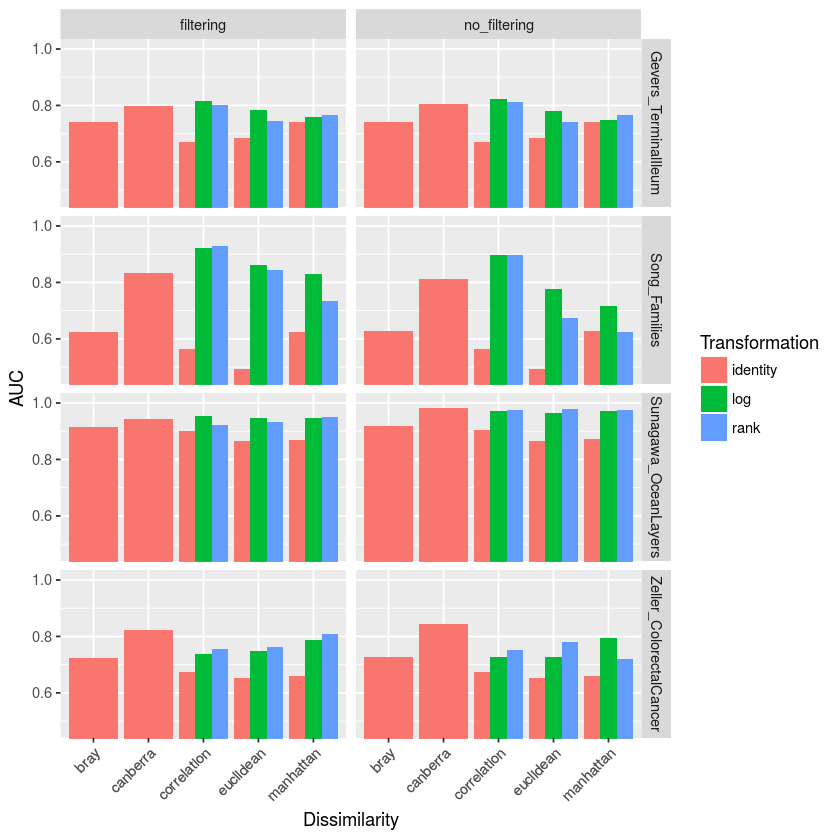

In [170]:
library(ggplot2)
p <- ggplot(results, aes(Dissimilarity, AUC)) + geom_bar(aes(fill = Transformation), stat = "identity", position = "dodge") + facet_grid(Dataset ~ Filtering)
p <- p + coord_cartesian(ylim = c(min(results$AUC)-0.025, max(results$AUC)+0.025))
p <- p + theme(axis.text.x = element_text(angle = 45, hjust = 1))
p

Notice that dissimilarity measures differ strongly in their performance in a relatively consistent manner across the observed data sets: The Canberra dissimilarity consistently outperforms all other identity transformed dissimilarity measures. Furthermore, note how data transformations are able to increase performance of dissimilarity measures consistently. The influence of taxon filtering appears to be strongly data set dependend:
Gevers_TerminalIleum and Sunagawa_OceanLayers show hardly any difference between filtered and unfiltered data, whereas Song_Families and Zeller_ColorectalCancer show marked strong differences especially for the rank-transformed Manhattan dissimilarity.

We have seen that dissimilarity measures differ widely in their ability to separate biological groups. Also, data transformations, especially the log transformation, appear to be very powerful. 

Let's now study the distortions of pairwise dissimilarities in the projections by ordination methods. We will benchmark group separation in low dimensional embeddings for two widely used ordination methods (PCoA and nMDS) and compare their AUC values to the AUC values obtained in original pairwise dissimilarity space to get an idea if and how group separation is suffering from projections into low dimensional space. Notice that in order to safe computation time, we have performed the ordination computation in the code block above.



In [171]:
results_nmds <- unlist(results_nmds)
results_nmds <- as.matrix(results_nmds)
results_nmds <- as.data.frame(results_nmds)
colnames(results_nmds) <- "AUC"
results_nmds$Dataset <- sapply(rownames(results_nmds), function(x) strsplit(x, split = "[.]")[[1]][1])
results_nmds$Filtering <- sapply(rownames(results_nmds), function(x) strsplit(x, split = "[.]")[[1]][2])
results_nmds$Transformation_Dissimilarity <- sapply(rownames(results_nmds), function(x) strsplit(x, split = "[.]")[[1]][3])
results_nmds$Transformation <- sapply(results_nmds$Transformation_Dissimilarity, function(x) strsplit(x, split = "_")[[1]][1])
results_nmds$Dissimilarity <- sapply(results_nmds$Transformation_Dissimilarity, function(x) strsplit(x, split = "_")[[1]][2])
results_nmds <- as.data.frame(apply(results_nmds, 2, unlist))
results_nmds[,1] <- as.numeric(as.vector(results_nmds[,1]))

results_pcoa <- unlist(results_pcoa)
results_pcoa <- as.matrix(results_pcoa)
results_pcoa <- as.data.frame(results_pcoa)
colnames(results_pcoa) <- "AUC"
results_pcoa$Dataset <- sapply(rownames(results_pcoa), function(x) strsplit(x, split = "[.]")[[1]][1])
results_pcoa$Filtering <- sapply(rownames(results_pcoa), function(x) strsplit(x, split = "[.]")[[1]][2])
results_pcoa$Transformation_Dissimilarity <- sapply(rownames(results_pcoa), function(x) strsplit(x, split = "[.]")[[1]][3])
results_pcoa$Transformation <- sapply(results_pcoa$Transformation_Dissimilarity, function(x) strsplit(x, split = "_")[[1]][1])
results_pcoa$Dissimilarity <- sapply(results_pcoa$Transformation_Dissimilarity, function(x) strsplit(x, split = "_")[[1]][2])
results_pcoa <- as.data.frame(apply(results_pcoa, 2, unlist))
results_pcoa[,1] <- as.numeric(as.vector(results_pcoa[,1]))

results$Representation <- rep("Original", dim(results)[1])
results_pcoa$Representation <- rep("PCoA", dim(results_pcoa)[1])
results_nmds$Representation <- rep("nMDS", dim(results_nmds)[1])
final_results <- rbind(results, results_pcoa, results_nmds)

In [172]:
# For sake of simplicity, plot only filtered data.
final_results <- final_results[which(final_results$Filtering == "filtering"), ]

# Use dplyr to compute mean over datasets
final_results <- final_results %>% group_by(Transformation_Dissimilarity, Representation) %>% mutate(meanAUC = mean(AUC))

# Change factor levels in order to have a sensible ordering.
summarized_means <- final_results %>% group_by(Transformation_Dissimilarity, Representation) %>% summarize(mean = mean(AUC))
summarized_means <- as.matrix(summarized_means[which(summarized_means$Representation == "Original"), ])
sorted_levels <- summarized_means[sort.int(summarized_means[,3], decreasing = FALSE, index.return = TRUE)$ix,1]

final_results$Transformation_Dissimilarity <- factor(final_results$Transformation_Dissimilarity, levels = sorted_levels)

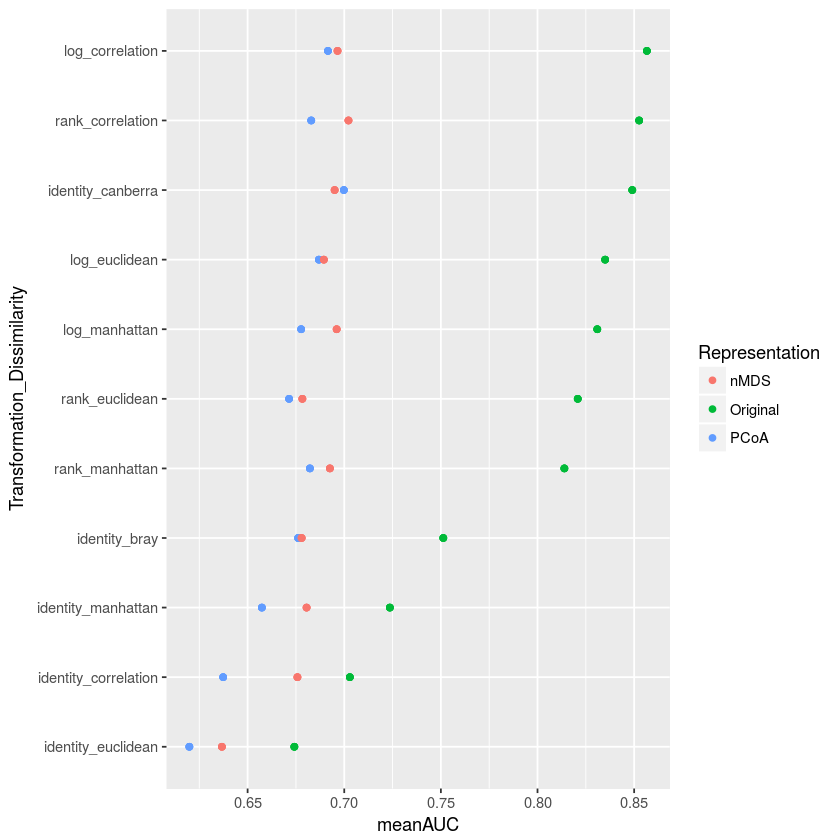

In [173]:
# TO GEORG: I would use one of the two following plots to convey the point.
ggplot(final_results, aes(meanAUC, Transformation_Dissimilarity, color = Representation)) + geom_point()

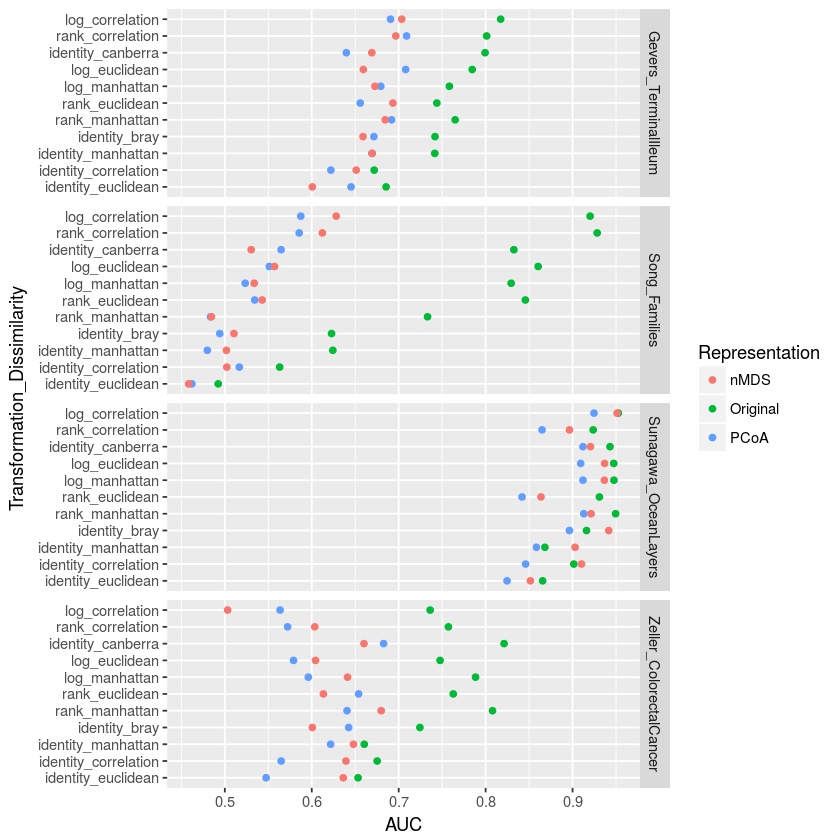

In [174]:
ggplot(final_results, aes(AUC, Transformation_Dissimilarity, color = Representation)) + geom_point() + facet_grid(Dataset ~ .)